#### Initialization

In [1]:
#pip install scipy
#pip instal pingouin

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pingouin as pg

In [3]:
class ftxt:
    """
    Provides strings for coloring/formatting text in the terminal.

    Colors: RED, GREEN, BLUE, YELLOW, PURPLE, CYAN.
        other Attributes:
            END (str): end the string with this to end text formatting
            BOLD (str): for writing bold text
            UNDERLINE (str): for writing underlined text        
    """

    RED = '\033[91m'
    GREEN = '\033[92m'
    BLUE = '\033[94m'
    YELLOW = '\033[93m'
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    END = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [4]:
ids_A = ["A8", "A10", "A11", "A12", "A14", "A15", "A16", "A17", "A18", "A19", "A20", "A21", "A22", "A23", "A24"]
ids_B = ["B4", "B5", "B6", "B7", "B9", "B11", "B12", "B13", "B14", "B15", "B16", "B17", "B18", "B19", "B20"]

Read experiment csv files into dictionarys

In [5]:
a_sample_dict, b_sample_dict, a_result_dict, b_result_dict = {}, {}, {}, {}
tmp = []

for id in ids_A:
    for i in range(125):
        tmp.append(pd.read_csv(fr"C:\Users\kevin\Desktop\ExperimentResults\Group_A\userID_{id}\SampledMetrics\trialIteration_{i}_samples.csv", sep=";"))
        #tmp[i].dropna(axis='columns')
    a_sample_dict[id] = tmp
    tmp = []
    
    #fixing broken first row in results 
    result_path = fr'C:\Users\kevin\Desktop\ExperimentResults\Group_A\userID_{id}'
    with open(fr"{result_path}\Result.csv", 'rt') as inp, open(fr"{result_path}\Result_edit.csv", 'wt') as out:
        writer = csv.writer(out)
        for row in csv.reader(inp):
            if row != ['sep=;']:
                writer.writerow(row)

    a_result_dict[id] = pd.read_csv(fr"{result_path}\Result_edit.csv", sep=";")
    # dropping irrelevant columns
    # a_result_dict[id].drop('TrialIteration', axis=1, inplace=True) # might be interesting, when sorting the columns after trialID
    a_result_dict[id].dropna(axis='columns', inplace=True)
    #a_result_dict[id] = a_result_dict[id].sort_values(by=['trialID'])
    a_result_dict[id]['trialID'] = pd.Series(a_result_dict[id]['trialID'], dtype="string").str.zfill(4)

for id in ids_B:
    for i in range(125):
        tmp.append(pd.read_csv(fr"C:\Users\kevin\Desktop\ExperimentResults\Group_B\userID_{id}\SampledMetrics\trialIteration_{i}_samples.csv", sep=";"))
        tmp[i].dropna(axis='columns')
        tmp[i].drop(columns=['g_r', 'injected_rotations', 'additional_virtual_rotation_accumulation',
                          'virtual_position', 'virtual_direction', 'virtual_euler', 'virtual_rotation'],
                    inplace=True)
    b_sample_dict[id] = tmp
    tmp = []

    #fixing broken first row in results 
    result_path = fr'C:\Users\kevin\Desktop\ExperimentResults\Group_B\userID_{id}'
    with open(fr"{result_path}\Result.csv", 'rt') as inp, open(fr"{result_path}\Result_edit.csv", 'wt') as out:
        writer = csv.writer(out)
        for row in csv.reader(inp):
            if row != ['sep=;']:
                writer.writerow(row)#
                
    b_result_dict[id] = pd.read_csv(fr"{result_path}\Result_edit.csv", sep=";")
    # dropping irrelevant columns
    b_result_dict[id].drop(columns=['min_g_r', 'max_g_r', 'g_r_average', 'sum_injected_rotation_g_r(IN DEGREES)', 'injected_rotation_average',
                                    'real_dir_at_virt_yaw', 'virt_dir_at_virt_yaw', 'max_yaw_virt', 'real_pos_at_virt_yaw', 'virt_pos_at_virt_yaw',
                                    'real_euler_at_real_yaw','virt_euler_at_real_yaw', 'real_euler_at_virt_yaw', 'virt_euler_at_virt_yaw',
                                    'real_rot_at_real_yaw',	'virt_rot_at_real_yaw', 'real_rot_at_virt_yaw' ,'virt_rot_at_virt_yaw'],
                           inplace=True)
    # b_result_dict[id].drop('TrialIteration', axis=1, inplace=True)  # might be interesting, when sorting the columns after trialID
    b_result_dict[id].dropna(axis='columns', inplace=True)
    #b_result_dict[id] = b_result_dict[id].sort_values(by=['trialID'])
    b_result_dict[id]['trialID'] = pd.Series(b_result_dict[id]['trialID'], dtype="string").str.zfill(4)

#a_result_dict['A10']
#b_result_dict['B4']
#a_sample_dict['A10'][25]
#a_result_dict['A10'].loc[:, 'min_g_r':'injected_rotation_average']

read questionnaire csv and concat to result csv

In [6]:
questionnaire_results = pd.read_csv(fr'C:\Users\kevin\Desktop\ExperimentResults\VR Ausweichstudie Fragebogen.csv')
questionnaire_results.drop('Bitte geben Sie an, ob Sie die Datenschutz- und Einverständniserklärung gelesen haben und fragen Sie den Versuchsleiter, falls Ihnen diese nicht vorgelegt wurde, diese durchzusehen und zu unterzeichnen.', axis=1, inplace=True)
questionnaire_results['ID Nummer'] = questionnaire_results['ID Nummer'].str.upper()
# renaming IPQ columns:                 # general "sense of being there"
questionnaire_results.rename(columns={'In der computererzeugten Welt hatte ich den Eindruck, dort gewesen zu sein... ': 'G1',
                                        # Spatial Presence
                                      'Ich hatte das Gefühl, daß die virtuelle Umgebung hinter mir weitergeht.': 'SP1',
                                      'Ich hatte das Gefühl, nur Bilder zu sehen. ': 'SP2',
                                      'Ich hatte nicht das Gefühl, in dem virtuellen Raum zu sein': "SP3",
                                      'Ich hatte das Gefühl, in dem virtuellen Raum zu handeln statt etwas von außen zu bedienen.': 'SP4',
                                      'Ich fühlte mich im virtuellen Raum anwesend. ': 'SP5',
                                        # Involvement 
                                      'Wie bewusst war Ihnen die reale Welt, während Sie sich durch die virtuelle Welt bewegten (z.B. Geräusche, Raumtemperatur, andere Personen etc.)? ':'INV1',
                                      'Meine reale Umgebung war mir nicht mehr bewusst.': 'INV2',
                                      'Ich achtete noch auf die reale Umgebung. ': 'INV3',
                                      'Meine Aufmerksamkeit war von der virtuellen Welt völlig in Bann gezogen. ':'INV4',
                                        # Experienced Realism
                                      'Wie real erschien Ihnen die virtuelle Umgebung? ': 'REAL1',
                                      'Wie sehr glich Ihr Erleben der virtuellen Umgebung dem Erleben einer realen Umgebung? ': "REAL2",
                                      'Wie real erschien Ihnen die virtuelle Welt? ': 'REAL3',
                                      'Die virtuelle Welt erschien mir wirklicher als die reale Welt. ': 'REAL4',                                      
                                      }, inplace=True)
questionnaire_results['VRSQ-Score'] = [None] * len(questionnaire_results)
questionnaire_results['SP-Score'] = [None] * len(questionnaire_results)
questionnaire_results['INV-Score'] = [None] * len(questionnaire_results)
questionnaire_results['REAL-Score'] = [None] * len(questionnaire_results)

questionnaire_dict = {}
for i in range(len(questionnaire_results)):
        questionnaire_dict[questionnaire_results.loc[i]['ID Nummer']] = questionnaire_results.loc[i]

#questionnaire_results
questionnaire_dict['B7']

Zeitstempel                                                                                                                             2022/12/27 8:09:30 PM MEZ
ID Nummer                                                                                                                                                      B7
Allgemeines Unwohlsein                                                                                                                                          1
Ermüdung                                                                                                                                                        3
Kopfschmerzen                                                                                                                                                   2
                                                                                                                                                  ...            
In welchem Ausmaß spielen Si

***
### Data preparation methods

In [7]:
trial_id_list = []         # list of all trial IDs
no_form_ids = set([])      # list of all trial IDs without form
no_size_ids = set([])      # list of all trial IDs without size
no_speed_ids = set([])     # list of all trial IDs without speed
no_angle_ids = set([])     # list of all trial IDs without angle

for i in range(len(a_result_dict['A10'])):
    trial_id = a_result_dict['A10'].iloc[i]['trialID']
    trial_id_list.append(trial_id)
    no_form_ids.add(trial_id[:0]+ trial_id[1:])
    no_size_ids.add(trial_id[:1] + trial_id[2:])
    no_speed_ids.add(trial_id[:2] + trial_id[3:])
    no_angle_ids.add(trial_id[:3])

trial_id = '1234'
slice = trial_id[:1]+ trial_id[2:]
print(slice)

134


In [8]:
class variable:
    name:str
    conditions:list[any]
    id_position:int
    sliced_id_list:list[int]
    german_name:str
    german_conditions:list[any]

    def __init__(self, name:str, conditions:list[any], id_position:int, sliced_id_list:list[int], german_name:str=None, german_conditions:list[any]=None):
        self.name = name
        self.conditions = conditions
        self.id_position = id_position
        self.sliced_id_list = sliced_id_list
        self.german_name = german_name
        self.german_conditions = german_conditions

    def slice_trial_id(self, trial_id:str):
        sliced_id = trial_id[:self.id_position]+ trial_id[self.id_position+1:]
        return sliced_id


form_var = variable('form', ['Sphere', 'Cylinder', 'Car'], 0, no_form_ids, 'Form', ['Kugel', 'Zylinder', 'Auto'])
size_var = variable('size', [0.3, 0.8], 1, no_size_ids, 'Größe', ['klein', 'groß'])
speed_var = variable('speed', [18, 24, 30], 2, no_speed_ids, 'Geschwindigkeit', ['18 km/h', '24 km/h', '30 km/h'])
angle_var = variable('angle', [40, 27, 13, 0, -13, -27, -40], 3, no_angle_ids, 'Winkel', ['40°', '27°', '13°', '0°', '-13°', '-27°', '-40°'])

In [9]:
def get_grouped_samples_for_key_by_variable(variable: variable, group_a_key:str, group_b_key=''):
    if group_b_key == '':
        group_b_key = group_a_key

    a_conditions = []
    b_conditions = []

    for condition in variable.conditions:
        a_samples = {}
        b_samples = {}

        for user_id in a_result_dict:
            condition_samples = a_result_dict[user_id].loc[a_result_dict[user_id][variable.name] == condition]

            for trial_id in condition_samples['trialID']:
                samples_by_trial = condition_samples.loc[condition_samples['trialID'] == trial_id][group_a_key].values[0]
                try:
                    a_samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
                except KeyError:
                    a_samples[f'{variable.slice_trial_id(trial_id)}'] = []
                    a_samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
        
        a_conditions.append(a_samples)
        
        
        for user_id in b_result_dict:
            condition_samples = b_result_dict[user_id].loc[b_result_dict[user_id][variable.name] == condition]

            for trial_id in condition_samples['trialID']:
                samples_by_trial = condition_samples.loc[condition_samples['trialID'] == trial_id][group_b_key].values[0]
                try:
                    b_samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
                except KeyError:
                    b_samples[f'{variable.slice_trial_id(trial_id)}'] = []
                    b_samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)

        b_conditions.append(b_samples)
    
    return a_conditions, b_conditions


def get_samples_for_key_by_variable(group:str, variable: variable, key:str):
    if group == 'A':
        result_dict = a_result_dict
    elif group == 'B':
        result_dict = b_result_dict
    else:
        print('Error: group must be A or B')
        return

    conditions = []

    for condition in variable.conditions:
        samples = {}

        for user_id in result_dict:
            condition_samples = result_dict[user_id].loc[result_dict[user_id][variable.name] == condition]

            for trial_id in condition_samples['trialID']:
                samples_by_trial = condition_samples.loc[condition_samples['trialID'] == trial_id][key].values[0]
                try:
                    samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
                except KeyError:
                    samples[f'{variable.slice_trial_id(trial_id)}'] = []
                    samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
        
        conditions.append(samples)
    
    return conditions

def get_samples_for_key_by_group(group:str, key:str):
    if group == 'A':
        result_dict = a_result_dict
    elif group == 'B':
        result_dict = b_result_dict
    else:
        print('Error: group must be A or B')
        return

    samples = {}

    for user_id in result_dict:
        for trial_id in result_dict[user_id]['trialID']:
            samples_by_trial = result_dict[user_id].loc[result_dict[user_id]['trialID'] == trial_id][key].values[0]
            try:
                samples[f'{trial_id}'].append(samples_by_trial)
            except KeyError:
                samples[f'{trial_id}'] = []
                samples[f'{trial_id}'].append(samples_by_trial)
    
    return samples

a_yaws_by_trial = get_samples_for_key_by_group('A', 'max_yaw_virt')
b_yaws_by_trial = get_samples_for_key_by_group('B', 'max_yaw_real')

#### Max yaws by size and trial

In [10]:
a_small_sized_yaws_by_trial = {}    # yaw per trial for small sized objects for Group A
b_small_sized_yaws_by_trial = {}    # yaw per trial for small sized objects for Group B
a_big_sized_yaws_by_trial = {}    # yaw per trial for big sized objects for group A
b_big_sized_yaws_by_trial = {}    # yaw per trial for big sized objects for group B
small_sized_trial_ids = []    # trial IDs for all small sized objects
big_sized_trial_ids = []    # trial IDs for all big sized objects
small_sized_yaws = []
big_sized_jaws = []

for user_id in a_result_dict:
    small_sizes = a_result_dict[user_id].loc[a_result_dict[user_id]['size'] == 0.3]

    for trial_id in small_sizes['trialID']:
        yaws_by_trial = small_sizes.loc[small_sizes['trialID'] == trial_id]['max_yaw_virt'].values[0]
        try:
            a_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        except KeyError:
            a_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'] = []
            a_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        small_sized_yaws.append(yaws_by_trial)

for user_id in b_result_dict:
    small_sizes = b_result_dict[user_id].loc[b_result_dict[user_id]['size'] == 0.3]

    for trial_id in small_sizes['trialID']:
        yaws_by_trial = small_sizes.loc[small_sizes['trialID'] == trial_id]['max_yaw_real'].values[0]
        try:
            b_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        except KeyError:
            b_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'] = []
            b_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        small_sized_yaws.append(yaws_by_trial)

for user_id_a in a_result_dict:
    big_sizes = a_result_dict[user_id_a].loc[a_result_dict[user_id_a]['size'] == 0.8]

    for trial_id in big_sizes['trialID']:
        big_sized_trial_ids.append(trial_id)
        yaws_by_trial = big_sizes.loc[big_sizes['trialID'] == trial_id]['max_yaw_virt'].values[0]
        try:
            a_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        except KeyError:
            a_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'] = []
            a_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        big_sized_jaws.append(f'{trial_id}')

for user_id_b in b_result_dict:
    big_sizes = b_result_dict[user_id_b].loc[b_result_dict[user_id_b]['size'] == 0.8]

    for trial_id in big_sizes['trialID']:
        yaws_by_trial = big_sizes.loc[big_sizes['trialID'] == trial_id]['max_yaw_real'].values[0]
        try:
            b_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        except KeyError:
            b_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'] = []
            b_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        big_sized_jaws.append(yaws_by_trial)


a_size_samples, b_size_samples = get_grouped_samples_for_key_by_variable(size_var, 'max_yaw_virt', 'max_yaw_real')

for trial_id in a_size_samples[0]:
    if a_big_sized_yaws_by_trial[trial_id] != a_size_samples[1][trial_id]:
        print(a_big_sized_yaws_by_trial[trial_id])
        print(a_size_samples[1][trial_id])

print(a_big_sized_yaws_by_trial['125'])
print(a_size_samples[1]['125'])
#print(len(big_sized_jaws))

[79.74974, -57.33629, -36.1325, -92.31796, 182.2314, -13.13463, -31.32183, -17.96552, -27.32403, -45.91121, 25.14571, -37.03136, 66.42007, -51.38204, -102.1654]
[79.74974, -57.33629, -36.1325, -92.31796, 182.2314, -13.13463, -31.32183, -17.96552, -27.32403, -45.91121, 25.14571, -37.03136, 66.42007, -51.38204, -102.1654]


***
### Data Visualization methods

In [11]:
def plot_test_data(a, b, title="", x_label_histogram="", show_probability_plot=True, show_histogram=True, bins=10, print_both=False):
    a_series = pd.Series(a)
    b_series = pd.Series(b)
    both = pd.Series(a + b)

    #Normal Distribution
    if show_probability_plot:
        def show_prob_plot(samples):
            fig = plt.figure(figsize= (20, 10))
            ax = fig.add_subplot(111)
            res = stats.probplot(samples, plot=plt, fit= True)
            plt.suptitle(title, fontsize= 20)
            ax.get_lines()[0].set_markerfacecolor('#b43092')
            ax.get_lines()[0].set_markeredgecolor('#b43092')
            ax.get_lines()[1].set_color('#ea5a00')
            plt.show()
        if(print_both):
            show_prob_plot(both)
        else:
            show_prob_plot(a)
            show_prob_plot(b)

    # equal variances
    if show_histogram:
        var_fig = plt.figure(figsize= (20, 10))
        ax = var_fig.add_subplot(111)
        if(print_both):
            plt.hist(both, color= '#ea5a00', label= "Beide Gruppen", density= True, alpha=0.75, bins=bins)
        else:
            plt.hist(a_series, color= '#ea5a00', label= "Gruppe A", density= True, alpha=0.75, bins=bins)
            plt.hist(b_series, color= '#b43092', label= "Gruppe B", density= True, alpha=0.75, bins=bins)
        plt.suptitle(title, fontsize= 20)
        plt.xlabel(x_label_histogram, fontsize= 16)
        plt.ylabel("Häufigkeitsdichte", fontsize= 16)
        .01, .99, 'matplotlib', 
        plt.text(.01, .99, f"Gruppe A: Mittelwert = {a_series.mean(): .1f}, Standardabweichung = {a_series.std(): .1f}", color='#ea5a00', ha='left', va='top', transform=ax.transAxes)
        plt.text(.01, .97, f"Gruppe B: Mittelwert = {b_series.mean(): .1f}, Standardabweichung = {b_series.std(): .1f}", color='#b43092', ha='left', va='top', transform=ax.transAxes)
        var_fig.tight_layout()
        plt.show()

In [112]:
def boxplot(values, value_names=['A', 'B'], title='', xlabel='', ylabel='', showfliers=True, subtitle='', subfontsize=16):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.suptitle(subtitle)
    ax.yaxis.grid(True)
    medianprops = dict(linewidth=2, color='#c81e0f')
    flierprops={'marker': 'D', 'markersize': 8, 'markeredgecolor': '#b43092'}#, 'markerfacecolor': '#ebd0e5'}
    bplot = ax.boxplot(values, labels=value_names, patch_artist=True, medianprops=medianprops, flierprops=flierprops, showfliers=showfliers)

    for patch in bplot['boxes']:
        patch.set_facecolor('#fcdac2')

    plt.show()

def subboxplot(ax: plt.Axes, values, value_names=['A', 'B'], title:str ='', xlabel:str='', ylabel:str='', hide_y_labels=False, xfontsizse=10):
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=xfontsizse)
    if(hide_y_labels):
        ax.set_yticklabels([])
        ax.set_ylabel("")
    else:
        ax.set_ylabel(ylabel)
    ax.yaxis.grid(True)
    medianprops = dict(linewidth=2, color='#c81e0f')
    flierprops={'marker': 'D', 'markersize': 8, 'markeredgecolor': '#b43092'} #'markerfacecolor': '#ebd0e5',
    bplot = ax.boxplot(values, labels=value_names, patch_artist=True, medianprops=medianprops, flierprops=flierprops)

    for patch in bplot['boxes']:
        patch.set_facecolor('#fcdac2')


***
### Independent and related tests including assumption checks

code taken from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html </br>
see also: https://stackoverflow.com/questions/12838993/scipy-normaltest-how-is-it-used </br>
see also: https://www.pythonfordatascience.org/independent-samples-t-test-python/ </br>

In [13]:
def cohens_d(x,y, digits=2):
    nx = len(x)
    ny = len(y)
    
    _, p_levene = stats.levene(x, y, center= 'mean')

    if nx == ny and p_levene > 0.05:
        d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
    else:
        dof = nx + ny - 2
        d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    
    cohens_d = abs(d)
    if cohens_d < 0.2:
        print(f'There is no effect. Effect size is d = {ftxt.GREEN}{d.round(digits)}{ftxt.END}.')
    elif cohens_d < 0.5:
        print(f'The effect size is d = {ftxt.YELLOW}{d.round(digits)}{ftxt.END} (small).')
    elif cohens_d < 0.8:
        print(f'The effect size is d = {ftxt.RED}{d.round(digits)}{ftxt.END} (medium).')
    else:
        print(f'The effect size is d = {ftxt.PURPLE}{d.round(digits)}{ftxt.END} (large).')
    return d

In [14]:
def independent_test(a, b, alpha=0.05, print_results=False, print_boxplot=False, digits=4):
    a_series = pd.Series(a)
    b_series = pd.Series(b)
    #both = pd.Series(a + b)

    if(print_boxplot):
        boxplot([a, b], value_names=['A', 'B'], title='Boxplot', xlabel='Gruppen', ylabel='Werte')

    hypothesis = True
    equal_var = True

    _, p_shapiro_a = stats.shapiro(a)                                     # ??? muss man die samples einzeln oder zusammen auf Normalverteilung testen ???
    _, p_shapiro_b = stats.shapiro(b)                                     # ??? muss man die samples einzeln oder zusammen auf Normalverteilung testen ???
    #_, p_normal = stats.normaltest(both)
    if p_shapiro_a > alpha and p_shapiro_b > alpha:
        if print_results:
            print(f'Shapiro-Wilk: The samples {ftxt.GREEN}*ARE*{ftxt.END} normally distributed: p_a = {p_shapiro_a}; p_b = {p_shapiro_b}')
    else:
        if print_results:
            if p_shapiro_a <= alpha:
                print(f'Shapiro-Wilk: The samples of a {ftxt.RED}*ARE NOT*{ftxt.END} normally distributed: p_a = {p_shapiro_a}')
            if p_shapiro_b <= alpha:
                print(f'Shapiro-Wilk: The samples of b {ftxt.RED}*ARE NOT*{ftxt.END} normally distributed: p_b = {p_shapiro_b}')

        # use Mann-Whitney U test for non-normal distribution
        statistic, p_mannwhitney = stats.mannwhitneyu(a_series, b_series)
        if p_mannwhitney > alpha:
            if print_results:
                print(f'{ftxt.YELLOW}MANN-WHITNEY:{ftxt.END} There {ftxt.BLUE}*IS NO*{ftxt.END} significant difference between the two sample sets: U = {statistic.round(digits)}; p = {p_mannwhitney.round(digits)}')
        else:
            if print_results:
                print(f'{ftxt.YELLOW}MANN-WHITNEY:{ftxt.END} There {ftxt.CYAN}*IS*{ftxt.END} a significant difference between the two sample sets: U = {statistic.round(digits)}; p = {p_mannwhitney.round(digits)}')
            hypothesis = False
            cohens_d(a_series, b_series, digits)
        
        # early Mann-Whitney U test return
        return hypothesis, p_mannwhitney, statistic, 'U-Wert'


    # equal variance
    _, p_levene = stats.levene(a_series, b_series, center= 'mean')
    if p_levene > alpha:
        if print_results:
            print(f'The samples {ftxt.GREEN}*HAVE*{ftxt.END} equal variances: p = {p_levene}')
    else:
        if print_results:
            print(f'The samples {ftxt.RED}*HAVE NO*{ftxt.END} equal variances: p = {p_levene}')
        equal_var = False
    

    # t-Test
    statistic, p_ttest = stats.ttest_ind(a_series, b_series, equal_var=equal_var)

    if p_ttest > alpha:
        if print_results:
            print(f'There {ftxt.BLUE}*IS NO*{ftxt.END} significant difference between the two sample sets: t = {statistic.round(digits)}; p = {p_ttest.round(digits)}')
    else:
        if print_results:
            print(f'There {ftxt.CYAN}*IS*{ftxt.END} a significant difference between the two sample sets: t = {statistic.round(digits)}; p = {p_ttest.round(digits)}')
        hypothesis = False
        cohens_d(a_series, b_series, digits)

    return hypothesis, p_ttest, statistic, 't-Wert'

In [15]:
def related_test(a, b, alpha=0.05, print_results=False, digits=4):
    a_series = pd.Series(a)
    b_series = pd.Series(b)
    both = pd.Series(a + b)

    hypothesis = True
    equal_var = True

    _, p_shapiro_a = stats.shapiro(a)                                     # ??? muss man die samples einzeln oder zusammen auf Normalverteilung testen ???
    _, p_shapiro_b = stats.shapiro(b)                                     # ??? muss man die samples einzeln oder zusammen auf Normalverteilung testen ???
    #_, p_normal = stats.normaltest(both)
    if p_shapiro_a > alpha and p_shapiro_b > alpha:
        if print_results:
            print(f'Shapiro-Wilk: The samples {ftxt.GREEN}*ARE*{ftxt.END} normally distributed: p_a = {p_shapiro_a}; p_b = {p_shapiro_b}')
    else:
        if print_results:
            if p_shapiro_a <= alpha:
                print(f'Shapiro-Wilk: The samples of group A {ftxt.RED}*ARE NOT*{ftxt.END} normally distributed: p_a = {p_shapiro_a}')
            if p_shapiro_b <= alpha:
                print(f'Shapiro-Wilk: The samples of group B {ftxt.RED}*ARE NOT*{ftxt.END} normally distributed: p_b = {p_shapiro_b}')

        # use Wilcoxon test for non-normal distribution
        stat, p_wilcoxon = stats.wilcoxon(a_series, b_series)
        if p_wilcoxon > alpha:
            if print_results:
                print(f'{ftxt.YELLOW}Wilcoxon:{ftxt.END} There {ftxt.BLUE}*IS NO*{ftxt.END} significant difference between the two sample sets: statistic = {stat.round(digits)}; p = {p_wilcoxon.round(digits)}')
        else:
            if print_results:
                print(f'{ftxt.YELLOW}Wilcoxon:{ftxt.END}  There {ftxt.CYAN}*IS*{ftxt.END} a significant difference between the two sample sets: statistic = {stat.round(digits)}; p = {p_wilcoxon.round(digits)}')
            hypothesis = False
            cohens_d(a_series, b_series, digits)
        
        # early Wilcoxon test return
        return hypothesis, p_wilcoxon, stat, 'Z-Wert'
    

    # t-Test
    t, p_ttest = stats.ttest_rel(a_series, b_series)

    if p_ttest > alpha:
        if print_results:
            print(f'There {ftxt.BLUE}*IS NO*{ftxt.END} significant difference between the two sample sets: statistic = {t.round(4)}; p = {p_ttest.round(4)}')
    else:
        if print_results:
            print(f'There {ftxt.CYAN}*IS*{ftxt.END} a significant difference between the two sample sets: statistic = {t.round(4)}; p = {p_ttest.round(4)}')
        hypothesis = False
        cohens_d(a_series, b_series, digits)

    return hypothesis, p_ttest, t, 't-Wert'

In [116]:
def evaluate_within_factor(within_factor:variable, group_a_dv='max_yaw_virt', group_b_dv='max_yaw_real', use_mean_over_all_samples=True):
    a_dict = pd.DataFrame(get_samples_for_key_by_variable('A', within_factor, group_a_dv))
    b_dict = pd.DataFrame(get_samples_for_key_by_variable('B', within_factor, group_b_dv))

    all_condition_samples = {}
    a_condition_means = {}
    b_condition_means = {}
    for con in within_factor.conditions:
        all_condition_samples[con] = []
        a_condition_means[con] = []
        b_condition_means[con] = []

    for col in a_dict.columns:
        for i, _ in enumerate(a_dict[col]):
            if use_mean_over_all_samples:
                all_condition_samples[within_factor.conditions[i]].append(abs(pd.Series(a_dict[col][i])).mean())
                all_condition_samples[within_factor.conditions[i]].append(abs(pd.Series(b_dict[col][i])).mean())
            else:
                all_condition_samples[within_factor.conditions[i]].extend(abs(pd.Series(a_dict[col][i])))
                all_condition_samples[within_factor.conditions[i]].extend(abs(pd.Series(b_dict[col][i])))
            a_condition_means[within_factor.conditions[i]].append(abs(pd.Series(a_dict[col][i])).mean())
            b_condition_means[within_factor.conditions[i]].append(abs(pd.Series(b_dict[col][i])).mean())

    #region evaluate condition means between each group
    if(within_factor == angle_var):
        factor_string = "Einfallswinkel"
        plots_per_row = 3
    else:
        plots_per_row = len(within_factor.conditions)

    if(within_factor == size_var):
        factor_string = "Größen"
    elif(within_factor == speed_var):
        factor_string = "Geschwindigkeits"
    elif(within_factor == form_var):
        factor_string = "Form"

    plot_width = 3
    fig, axs = plt.subplots(1, plots_per_row, figsize=(plots_per_row*plot_width, 5))
    i, j = 0, 0
    
    for k, con in enumerate(within_factor.conditions):
        print('************************************************************ Signifikanz zwischen Gruppen für', within_factor.german_name, con, '******************************')
        _, p, stat, method = independent_test(a_condition_means[con], b_condition_means[con], print_results=True, digits=200)
        p_format = '{:.2g}'.format(p)
        stat_format = '{:.2g}'.format(stat)
        subboxplot(axs[j], [a_condition_means[con], b_condition_means[con]], title=f'{within_factor.german_conditions[k]}', ylabel='α-Absolutwert', xlabel=f'Gruppe\n{method} = {stat_format}; p-Wert = {p_format}', xfontsizse=11.5)
        axs[j].sharey(axs[0]) #p.round(4)
        print(plt.ylim())
        
        j += 1
        if j == plots_per_row and within_factor == angle_var:
            fig.suptitle(f'Verteilung der Mittelwerte der absoluten α-Werte jeder Messung\ninnerhalb der {factor_string}stufen zwischen beiden Gruppen', fontsize=15)
            for ax in axs.flat:
                ax.label_outer()
            fig.tight_layout()
            plt.ylim(25.317985306666667, 101.72287416)  # hard coded for first 3 angle_var conditions
            plt.show()
            if(i < 1):
                plots_per_row = 4
                fig, axs = plt.subplots(1, plots_per_row, figsize=(3*4, 5))
            j = 0
            i += 1        

    fig.suptitle(f'Verteilung der Mittelwerte der absoluten α-Werte jeder Messung\ninnerhalb der {factor_string}stufen zwischen beiden Gruppen', fontsize=15)
    for ax in axs.flat:
        ax.label_outer()
    fig.tight_layout()
    plt.show()
    #endregion
    
    boxplot_samples = []
    tested_condiions = set()
    for con1 in within_factor.conditions:
        boxplot_samples.append(all_condition_samples[con1])
        for con2 in within_factor.conditions:
            if con1 == con2 or (con1, con2) in tested_condiions or (con2, con1) in tested_condiions:
                continue
            tested_condiions.add((con1, con2))
            print('************************************************************ Signifikanz zwischen Bedingungen für', within_factor.german_name, con1, 'und', con2, '******************************')
            _, p, stat, method = related_test(all_condition_samples[con1], all_condition_samples[con2], print_results=True, digits=200)

    boxplot(boxplot_samples, title=f'Verteilung der Mittelwerte der absoluten α-Werte jeder Messung\nzwischen den {factor_string}stufen innerhalb beider Gruppen', xlabel=f'{within_factor.german_name}', ylabel='α-Absolutwert', value_names=within_factor.german_conditions)

    if(within_factor == angle_var):        
        boxplot_samples = []
        boxplot_labels = []
        tested_condiions = set()
        added_boxplot_samples = set()
        for con1 in within_factor.conditions:
            if con1 == 0:
                continue
            abscon1 = all_condition_samples[con1]+all_condition_samples[-con1]

            for con2 in within_factor.conditions:
                if abs(con1) == abs(con2) or (abs(con1), abs(con2)) in tested_condiions or (abs(con2), abs(con1)) in tested_condiions:
                    continue
                tested_condiions.add((abs(con1), abs(con2)))
                abscon2 = all_condition_samples[con2]+all_condition_samples[-con2]
                print('************************************************************ Signifikanz zwischen Bedingungen für', within_factor.german_name, con1, 'und', con2, '******************************')
                _, p, stat, method = related_test(abscon1, abscon2, print_results=True, digits=200)
                
                if abs(con2) in added_boxplot_samples or abs(con1) in added_boxplot_samples:
                    continue
                boxplot_samples.append(abscon1)
                boxplot_labels.append(abs(con1))
                boxplot_samples.append(abscon2)
                boxplot_labels.append(abs(con2))
                added_boxplot_samples.add(abs(con1))
                added_boxplot_samples.add(abs(con2))
        
        boxplot(boxplot_samples, title=f'Verteilung der Mittelwerte der absoluten α-Werte jeder Messung\nzwischen den absoluten Einfallswinkelstufen innerhalb beider Gruppen', xlabel='Absolute Einfallswinkel', ylabel='α-Absolutwert', value_names=boxplot_labels)

#evaluate_within_factor(size_var, use_mean_over_all_samples=True)

***
### Questionnaire Data

#### VRSQ

Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.07096214592456818; p_b = 0.751789391040802
The samples *HAVE* equal variances: p = 0.5706815930512352
There *IS NO* significant difference between the two sample sets: t = 0.5872; p = 0.5618


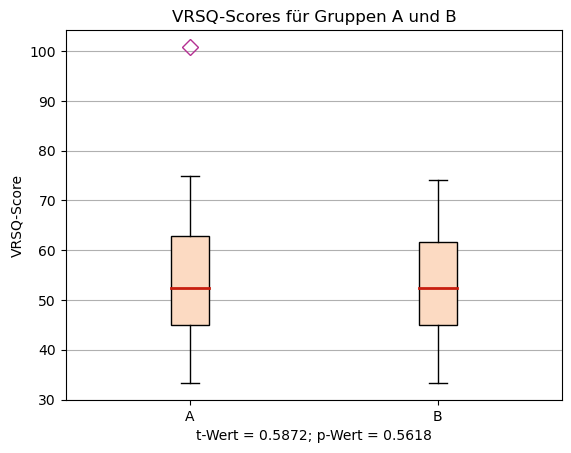

In [17]:
b_scores, a_scores = [], []

for user_key in questionnaire_dict:
    # if(user_key == 'A12'):
    #     continue
    user_answers = questionnaire_dict[user_key]
    a = user_answers['Allgemeines Unwohlsein'] + user_answers['Ermüdung'] + user_answers['Kopfschmerzen'] + user_answers['angestrengte Augen']
    b = user_answers['Schwierigkeiten scharf zu sehen'] + user_answers['Kopfdruck'] + user_answers['Verschwommenes Sehen'] + user_answers['Schwindel bei geschlossenen Augen'] + user_answers['Gleichgewichtsstörungen']
    c = a / 12 * 100
    d = b / 15 * 100
    user_score = (c + d) / 2
    questionnaire_dict[user_key]['VRSQ-Score'] = user_score
    #print('VRSQ Score for', user_answers['ID Nummer'], 'is', questionnaire_dict[user_key]['VRSQ-Score'])

    if 'A' in user_key:
        a_scores.append(user_score)
    elif 'B' in user_key:
        b_scores.append(user_score)

_, p, t_stat, method = independent_test(a_scores, b_scores, print_results= True)
boxplot([a_scores, b_scores], title='VRSQ-Scores für Gruppen A und B', xlabel=f'{method} = {t_stat.round(4)}; p-Wert = {p.round(4)}', ylabel='VRSQ-Score')

#### IPQ Scores:

Genereal sense of being there:
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.5790197253227234; p_b = 0.31636592745780945
The samples *HAVE* equal variances: p = 0.20412774932965297
There *IS NO* significant difference between the two sample sets: t = -0.7174; p = 0.4791

Spatial Presence:
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.23939655721187592; p_b = 0.39890605211257935
The samples *HAVE* equal variances: p = 0.17769364302686055
There *IS NO* significant difference between the two sample sets: t = 0.256; p = 0.7998

Involvement:
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.09412603825330734; p_b = 0.5164908170700073
The samples *HAVE* equal variances: p = 0.894022537626751
There *IS NO* significant difference between the two sample sets: t = -0.2119; p = 0.8337

Realism:
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.7133517265319824; p_b = 0.39409011602401733
The samples *HAVE* equal variances: p = 0.0959700725978

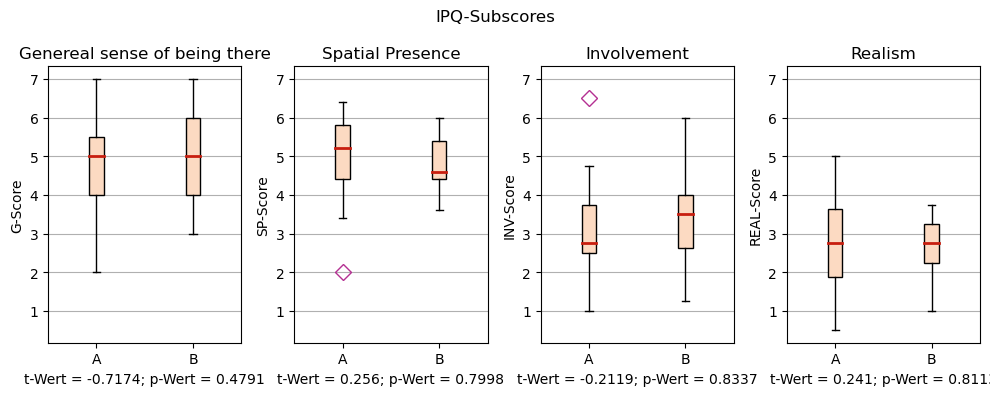

In [48]:
a_g, a_sp, a_inv, a_real = [], [], [], []
b_g, b_sp, b_inv, b_real = [], [], [], []
count_a, count_b = 0, 0

for key in questionnaire_dict:
    user_answers = questionnaire_dict[key]
    # calculate mean of each sub-score and invert SP2, INV3 and REAL1
    sp = (user_answers['SP1'] + (-1 * user_answers['SP2'] + 6) + user_answers['SP3'] + user_answers['SP4'] + user_answers['SP5']) / 5
    inv = (user_answers['INV1'] + user_answers['INV2'] + (-1 * user_answers['INV3'] + 6) + user_answers['INV4']) / 4
    real = ((-1 * user_answers['REAL1'] + 6) + user_answers['REAL2'] + user_answers['REAL3'] + user_answers['REAL4']) / 4

    questionnaire_dict[key]['SP-Score'] = sp
    questionnaire_dict[key]['INV-Score'] = inv
    questionnaire_dict[key]['REAL-Score'] = real

    # sum up scores of all keys containing A and B
    if 'A' in key:
        a_g.append(questionnaire_dict[key]['G1'])
        a_sp.append(sp)
        a_inv.append(inv)
        a_real.append(real)
    elif 'B' in key:
        b_g.append( questionnaire_dict[key]['G1'])
        b_sp.append(sp)
        b_inv.append(inv)
        b_real.append(real)

print('Genereal sense of being there:')
_, p_g, t_g, g_method = independent_test(a_g, b_g, print_results=True)
print()
print('Spatial Presence:')
_, p_sp, t_sp, sp_method = independent_test(a_sp, b_sp, print_results=True)
print()
print('Involvement:')
_, p_inv, t_inv, inv_method = independent_test(a_inv, b_inv, print_results=True)
print()
print('Realism:')
_, p_real, t_real, real_method = independent_test(a_real, b_real, print_results=True)

def plots_in_a_row():
    fig, axs = plt.subplots(1, 4, figsize=(10, 4))
    subboxplot(axs[0], [a_g, b_g], title='Genereal sense of being there', ylabel='G-Score', xlabel=f'{g_method} = {t_g.round(4)}; p-Wert = {p_g.round(4)}')
    subboxplot(axs[1],[a_sp, b_sp], title='Spatial Presence', ylabel='SP-Score', xlabel=f'{sp_method} = {t_sp.round(4)}; p-Wert = {p_sp.round(4)}')
    subboxplot(axs[2],[a_inv, b_inv], title='Involvement', ylabel='INV-Score', xlabel=f'{inv_method} = {t_inv.round(4)}; p-Wert = {p_inv.round(4)}')
    subboxplot(axs[3],[a_real, b_real], title='Realism', ylabel='REAL-Score', xlabel=f'{real_method} = {t_real.round(4)}; p-Wert = {p_real.round(4)}')
    axs[1].sharey(axs[0])
    axs[2].sharey(axs[0])
    axs[3].sharey(axs[0])

    fig.suptitle('IPQ-Subscores')    
    fig.tight_layout()

    plt.show()

plots_in_a_row()

#### Eigene Fragen:

In [19]:
perception_value, perception_count = 0, 0
user_count = 0
aware_users = []

for key in questionnaire_dict:
    if 'A' in key:
        value = questionnaire_dict[key]['Ich habe bemerkt, dass die virtuelle Welt um mich rotiert wurde.']
        if not np.isnan(value):
            user_count += 1
        if(value > 1):
            aware_users.append([key, value])
            perception_value += value
            perception_count += 1

print(len(aware_users),'Aware Users:', aware_users)
print('Perception Ratio:', perception_count / user_count)
print('Perception Mean Score:', perception_value / perception_count)
print('An jedem Experimentort wurde die Rotation mindestens einmal bemerkt. Im größten Eyperimentort 5 sogar von zwei Teilnehmern.')
#questionnaire_dict['A12']['Ich habe bemerkt, dass die virtuelle Welt um mich rotiert wurde.']

6 Aware Users: [['A11', 4.0], ['A12', 3.0], ['A14', 4.0], ['A17', 5.0], ['A22', 4.0], ['A23', 5.0]]
Perception Ratio: 0.46153846153846156
Perception Mean Score: 4.166666666666667
An jedem Experimentort wurde die Rotation mindestens einmal bemerkt. Im größten Eyperimentort 5 sogar von zwei Teilnehmern.


In [20]:
disruptiveness = 0
for key in aware_users:
    value = questionnaire_dict[key[0]]['Ich empfand die Rotation der virtuellen Welt als störend.']
    print(value)
    disruptiveness += value

disruptiveness /= len(aware_users)
print('Mean Disruptiveness:', disruptiveness)

print('Users unaware of rotation but perceived rotation as disruptive:')
for key in questionnaire_dict:
    disruptiveness = questionnaire_dict[key]['Ich empfand die Rotation der virtuellen Welt als störend.']
    if disruptiveness > 1 and key not in aware_users:
        print(key, disruptiveness)

2.0
3.0
2.0
1.0
2.0
1.0
Mean Disruptiveness: 1.8333333333333333
Users unaware of rotation but perceived rotation as disruptive:
A11 2.0
A12 3.0
A14 2.0
B15 2.0
A20 2.0
A22 2.0


In [21]:
for key in aware_users:
    print(key, questionnaire_dict[key[0]]['Durch das blaue Gitter habe ich bemerkt, dass die virtuelle Welt rotiert wird.'])

for key in aware_users:
    print(key, questionnaire_dict[key[0]]['Wie oft haben Sie das blaue Gitter, das den Rand des Tracking Spaces signalisiert, wahrgenommen?'])

['A11', 4.0] 2.0
['A12', 3.0] 1.0
['A14', 4.0] 2.0
['A17', 5.0] 4.0
['A22', 4.0] 1.0
['A23', 5.0] 1.0
['A11', 4.0] in 25-50% der Tests wahrgenommen
['A12', 3.0] in 4-25% der Tests wahrgenommen
['A14', 4.0] in 4-25% der Tests wahrgenommen
['A17', 5.0] in 75-100% der Tests wahrgenommen
['A22', 4.0] 1-5 mal wahrgenommen
['A23', 5.0] 1-5 mal wahrgenommen


In [22]:
#questionnaire_dict['A12'].keys()
aware_users = []
perception_count, perception_value = 0, 0

for key in questionnaire_dict:
    if 'A' in key:
        value = questionnaire_dict[key]['Ich sollte mich vor jedem Test an die gleiche Stelle im realen Raum stellen.']
        if not np.isnan(value):
            user_count += 1
        if(value < 5):
            aware_users.append([key, value])
            perception_value += value
            perception_count += 1

print(len(aware_users),'Aware Users:', aware_users)
print('Perception Ratio:', perception_count / user_count)
print('Perception Mean Score:', perception_value / perception_count)
#Ich sollte mich vor jedem Test an die gleiche Stelle im realen Raum stellen.

10 Aware Users: [['A11', 1.0], ['A12', 1.0], ['A15', 1.0], ['A17', 3.0], ['A18', 3.0], ['A20', 3.0], ['A21', 1.0], ['A22', 4.0], ['A23', 1.0], ['A24', 3.0]]
Perception Ratio: 0.38461538461538464
Perception Mean Score: 2.1


***
### Forschungsfragen

##### 4.1.3 α BEI AUSWEICHMANÖVERN OHNE ROTATIONSVERSTÄRKUNG (αR) ZEIGT KEINE SIGNIFIKANTEN UN-TERSCHIEDE ZU α IM VIRTUELLEN RAUM BEI EINGESCHALTETER ROTATIONSVERSTÄRKUNG (αV).

H3: α BEI AUSWEICHMANÖVERN OHNE ROTATIONSVERSTÄRKUNG (αR) ZEIGT KEINE SIGNIFIKANTEN UN-TERSCHIEDE ZU α IM VIRTUELLEN RAUM BEI EINGESCHALTETER ROTATIONSVERSTÄRKUNG (αV).
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.7551578879356384; p_b = 0.33786702156066895
The samples *HAVE NO* equal variances: p = 0.01694670974520895
There *IS* a significant difference between the two sample sets: t = -9.987624600612419; p = 7.183746924649401e-20
The effect size is d = -1.2583224229281555 (large).


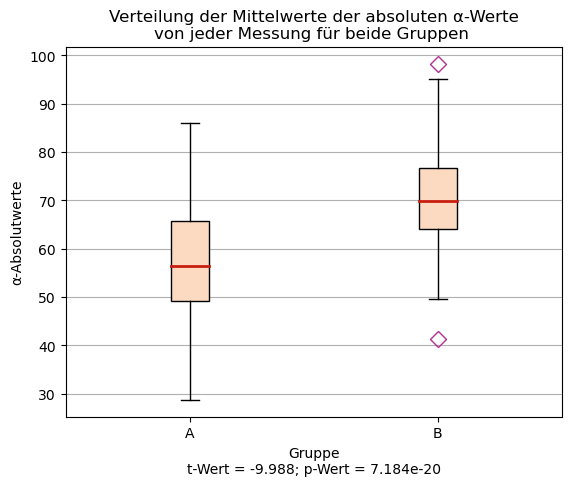

Standardabweichung: A:  11.624953917725668 ; B:  9.475152465594654
Mittelwerte: A:  11.624953917725668 ; B:  70.97489159280424
Mediane: A:  11.624953917725668 ; B:  69.90802533333334


In [86]:
print(f'H3: α BEI AUSWEICHMANÖVERN OHNE ROTATIONSVERSTÄRKUNG (αR) ZEIGT KEINE SIGNIFIKANTEN UN-TERSCHIEDE ZU α IM VIRTUELLEN RAUM BEI EINGESCHALTETER ROTATIONSVERSTÄRKUNG (αV).')
hypothesis_counter = 0
significant_trials = []

a_samples = get_samples_for_key_by_group('A', 'max_yaw_virt')
b_samples = get_samples_for_key_by_group('B', 'max_yaw_real')
a_means, b_means = [], []

for trial_id in trial_id_list:
    a_means.append(abs(pd.Series(a_samples[f'{trial_id}'])).mean())
    b_means.append(abs(pd.Series(b_samples[f'{trial_id}'])).mean())

hypothesis, p, stat, method = independent_test(a_means, b_means, print_results=True, digits=200)
p_format = '{:.4g}'.format(p)
stat_format = '{:.4g}'.format(stat)
boxplot([a_means, b_means], title=f'Verteilung der Mittelwerte der absoluten α-Werte\nvon jeder Messung für beide Gruppen ', ylabel='α-Absolutwerte', xlabel=f'Gruppe\n{method} = {stat_format}; p-Wert = {p_format}')
print('Standardabweichung: A: ', pd.Series(a_means).std(), '; B: ', pd.Series(b_means).std())
print('Mittelwerte: A: ', pd.Series(a_means).std(), '; B: ', pd.Series(b_means).mean())
print('Mediane: A: ', pd.Series(a_means).std(), '; B: ', pd.Series(b_means).median())

##### 4.1.4 GRÖßERE OBJEKTE RUFEN BEIM AUSWEICHEN GRÖßERE α-WERTE HERVOR ALS KLEINERE OBJEKTE.

************************************************************ Signifikanz zwischen Gruppen für Größe 0.3 ******************************
Shapiro-Wilk: The samples of b *ARE NOT* normally distributed: p_b = 0.030906738713383675
MANN-WHITNEY: There *IS* a significant difference between the two sample sets: U = 724.0; p = 7.857182550633597e-10
The effect size is d = -1.25576784780572 (large).
(0.0, 1.0)
************************************************************ Signifikanz zwischen Gruppen für Größe 0.8 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.4239632785320282; p_b = 0.2853727638721466
The samples *HAVE* equal variances: p = 0.20695221031576883
There *IS* a significant difference between the two sample sets: t = -7.041103640449861; p = 1.1530033607987179e-10
The effect size is d = -1.2545427355871483 (large).
(25.317985306666667, 101.72287416)


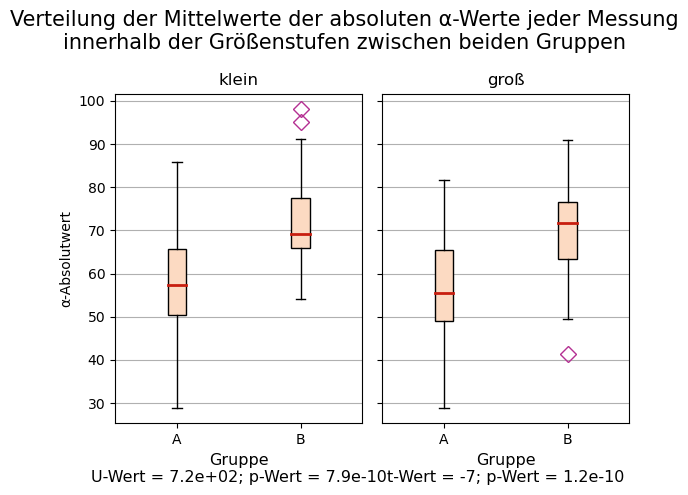

************************************************************ Signifikanz zwischen Bedingungen für Größe 0.3 und 0.8 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.5675185918807983; p_b = 0.17307992279529572
There *IS NO* significant difference between the two sample sets: statistic = 1.1468; p = 0.2536


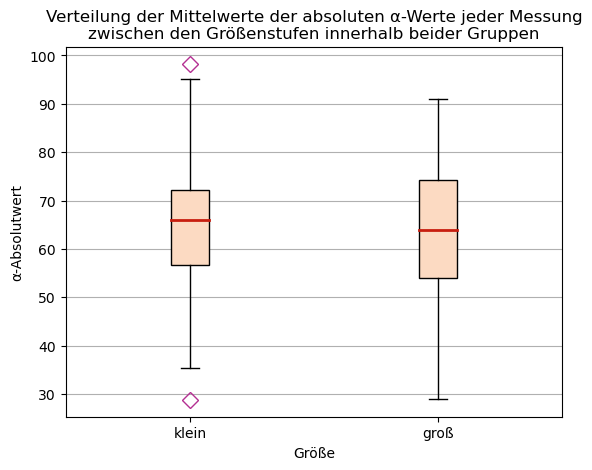

In [117]:
all_samples_ = evaluate_within_factor(size_var, use_mean_over_all_samples=True)

#### 4.1.5 LANGSAMERE GESCHWINDIGKEITEN RUFEN BEIM AUSWEICHEN GRÖßERE α-WERTE HERVOR ALS SCHNELLERE.

************************************************************ Signifikanz zwischen Gruppen für Geschwindigkeit 18 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.6691866517066956; p_b = 0.11998530477285385
The samples *HAVE* equal variances: p = 0.883600857526172
There *IS* a significant difference between the two sample sets: t = -4.372435317826624; p = 3.579681115121991e-05
The effect size is d = -0.9541436102494668 (large).
(0.0, 1.0)
************************************************************ Signifikanz zwischen Gruppen für Geschwindigkeit 24 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.650091290473938; p_b = 0.8511393070220947
The samples *HAVE* equal variances: p = 0.08409283057202128
There *IS* a significant difference between the two sample sets: t = -7.907472120985345; p = 1.0651961098281884e-11
The effect size is d = -1.7255518833413492 (large).
(0.0, 1.0)
***************************

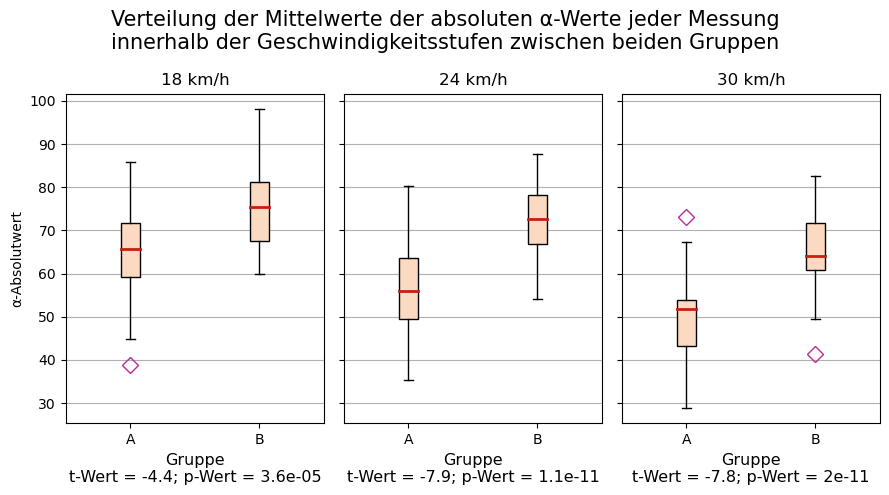

************************************************************ Signifikanz zwischen Bedingungen für Geschwindigkeit 18 und 24 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.6648173928260803; p_b = 0.1477556973695755
There *IS* a significant difference between the two sample sets: statistic = 4.8263; p = 0.0
The effect size is d = 0.49910875859972226 (small).
************************************************************ Signifikanz zwischen Bedingungen für Geschwindigkeit 18 und 30 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.6648173928260803; p_b = 0.598619818687439
There *IS* a significant difference between the two sample sets: statistic = 11.1774; p = 0.0
The effect size is d = 1.091840767060394 (large).
************************************************************ Signifikanz zwischen Bedingungen für Geschwindigkeit 24 und 30 ******************************
Shapiro-Wilk: The samples *ARE* norma

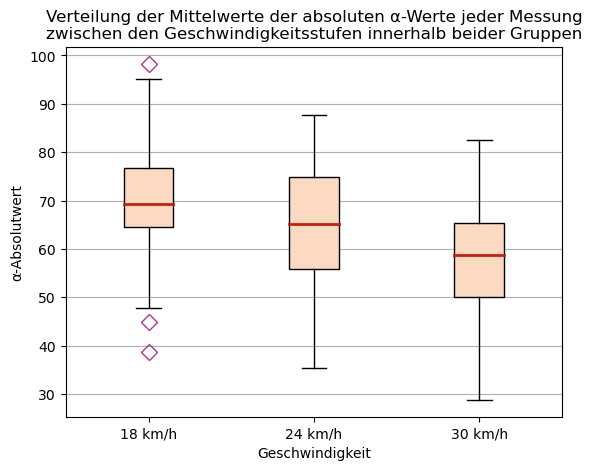

In [120]:
all_samples_ = evaluate_within_factor(speed_var, use_mean_over_all_samples=True)

#### 4.1.6 OBJEKTE, DIE SICH AUS DEM ZENTRALEN GESICHTSFELD (±30°) AUF DIE USER ZU BEWEGEN, RUFEN BEIM AUSWEICHEN GERINGERE α-WERTE HERVOR.

************************************************************ Signifikanz zwischen Gruppen für Winkel 40 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.44460391998291016; p_b = 0.7077906131744385
The samples *HAVE* equal variances: p = 0.9558555828939089
There *IS* a significant difference between the two sample sets: t = -3.622249159646465; p = 0.0009419012759370377
The effect size is d = -1.2074163865488214 (large).
(0.0, 1.0)
************************************************************ Signifikanz zwischen Gruppen für Winkel 27 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.2642713189125061; p_b = 0.9658455848693848
The samples *HAVE NO* equal variances: p = 0.009808484710782418
There *IS* a significant difference between the two sample sets: t = -4.683004747819596; p = 6.494992508977863e-05
The effect size is d = -1.5610015826065318 (large).
(0.0, 1.0)
****************************************

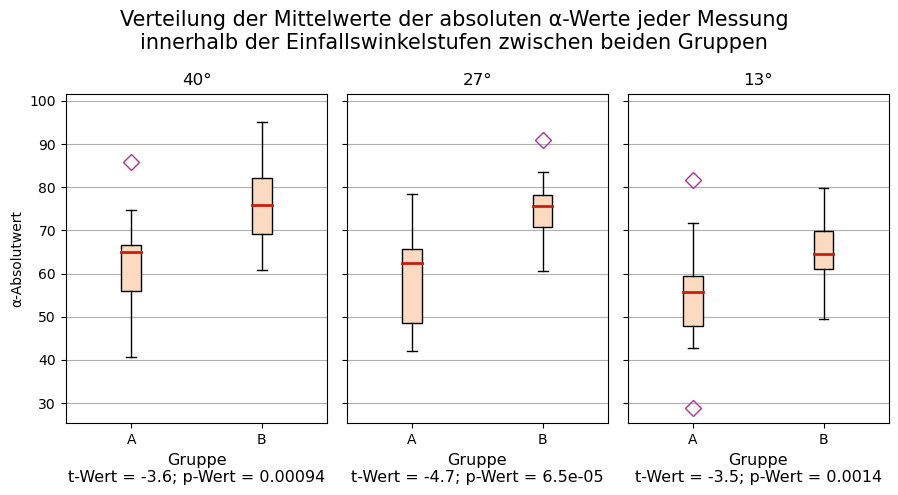

************************************************************ Signifikanz zwischen Gruppen für Winkel 0 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.17127224802970886; p_b = 0.09389479458332062
The samples *HAVE NO* equal variances: p = 0.035172509231932846
There *IS* a significant difference between the two sample sets: t = -2.0989656489260384; p = 0.0447954280735538
The effect size is d = -0.6996552163086794 (medium).
(0.0, 1.0)
************************************************************ Signifikanz zwischen Gruppen für Winkel -13 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.8867831230163574; p_b = 0.3606010973453522
The samples *HAVE* equal variances: p = 0.20941847279490614
There *IS* a significant difference between the two sample sets: t = -4.5425595736859625; p = 6.675947671438967e-05
The effect size is d = -1.5141865245619872 (large).
(0.0, 1.0)
**************************************

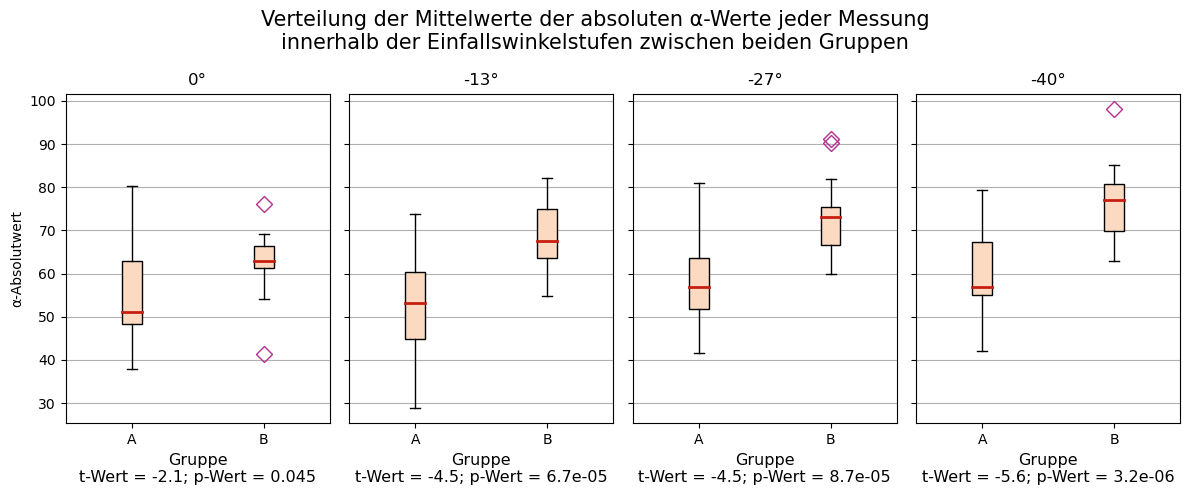

************************************************************ Signifikanz zwischen Bedingungen für Winkel 40 und 27 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.9211199879646301; p_b = 0.08256692439317703
There *IS NO* significant difference between the two sample sets: statistic = 0.7725; p = 0.445
************************************************************ Signifikanz zwischen Bedingungen für Winkel 40 und 13 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.9211199879646301; p_b = 0.6566754579544067
There *IS* a significant difference between the two sample sets: statistic = 4.6418; p = 0.0
The effect size is d = 0.78393370388366 (medium).
************************************************************ Signifikanz zwischen Bedingungen für Winkel 40 und 0 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.9211199879646301; p_b = 0.5674722194671631
There *I

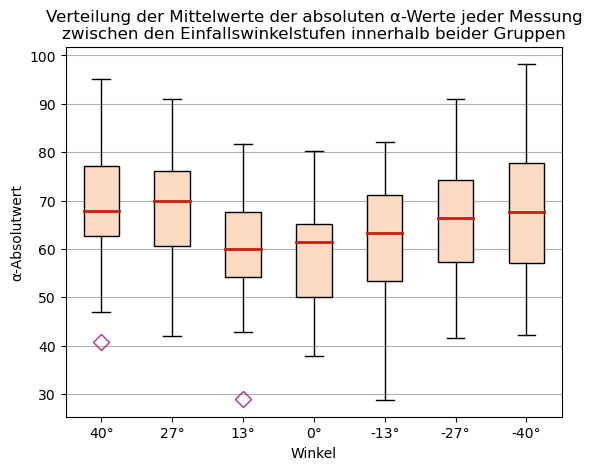

************************************************************ Signifikanz zwischen Bedingungen für Winkel 40 und 27 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.8078581690788269; p_b = 0.07648705691099167
There *IS NO* significant difference between the two sample sets: statistic = 1.7792; p = 0.0795
************************************************************ Signifikanz zwischen Bedingungen für Winkel 40 und 13 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.8078581690788269; p_b = 0.21495118737220764
There *IS* a significant difference between the two sample sets: statistic = 6.6257; p = 0.0
The effect size is d = 0.6939328003284001 (medium).
************************************************************ Signifikanz zwischen Bedingungen für Winkel 40 und 0 ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.8078581690788269; p_b = 0.08497686684131622
The

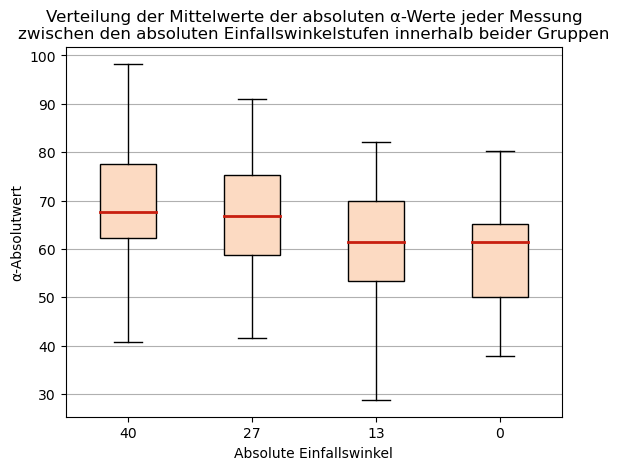

In [118]:
all_samples = evaluate_within_factor(angle_var, use_mean_over_all_samples=True)

#### 4.1.7 DIE FORM DER OBJEKTE HAT KEINEN SIGNIFIKANTEN EINFLUSS AUF α.

************************************************************ Signifikanz zwischen Gruppen für Form Sphere ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.9723299145698547; p_b = 0.07198406010866165
The samples *HAVE* equal variances: p = 0.29543940311462985
There *IS* a significant difference between the two sample sets: t = -8.999130452977093; p = 7.225664361878232e-14
The effect size is d = -1.9637712614071312 (large).
(0.0, 1.0)
************************************************************ Signifikanz zwischen Gruppen für Form Cylinder ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.5858103632926941; p_b = 0.5569165945053101
The samples *HAVE* equal variances: p = 0.1507786563032093
There *IS* a significant difference between the two sample sets: t = -4.256876839488885; p = 5.480298498094782e-05
The effect size is d = -0.9289266829077234 (large).
(0.0, 1.0)
**************************************

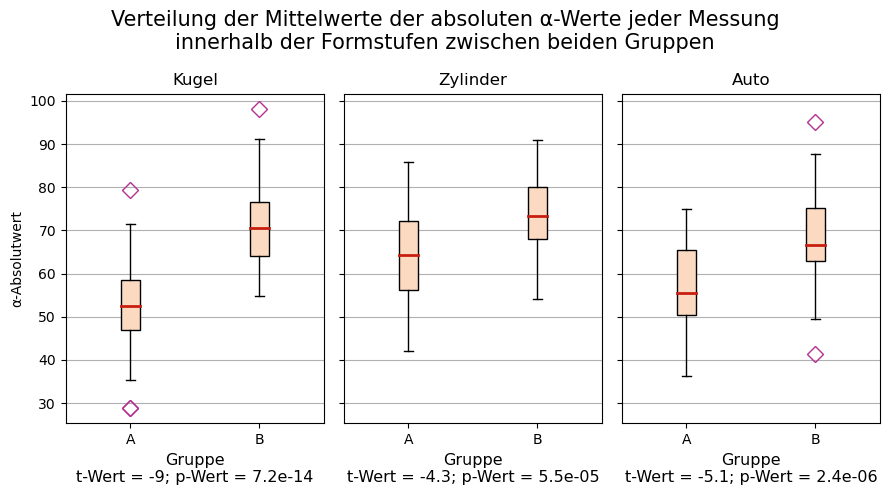

************************************************************ Signifikanz zwischen Bedingungen für Form Sphere und Cylinder ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.9235779643058777; p_b = 0.15503805875778198
There *IS* a significant difference between the two sample sets: statistic = -4.7533; p = 0.0
The effect size is d = -0.5202979679596343 (medium).
************************************************************ Signifikanz zwischen Bedingungen für Form Sphere und Car ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.9235779643058777; p_b = 0.8160101771354675
There *IS NO* significant difference between the two sample sets: statistic = -0.9032; p = 0.369
************************************************************ Signifikanz zwischen Bedingungen für Form Cylinder und Car ******************************
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.15503805875778198; p_b = 0.81

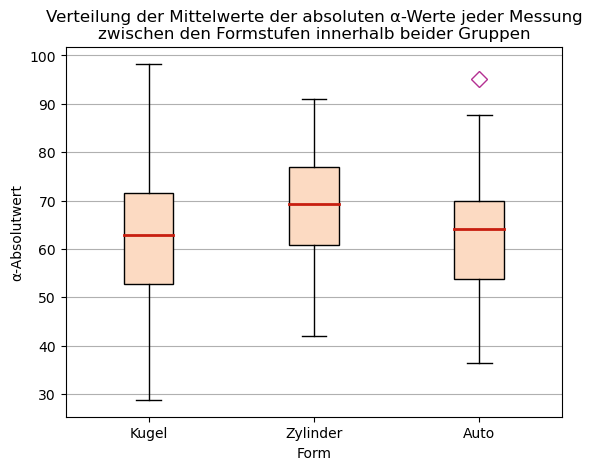

In [119]:
evaluate_within_factor(form_var, use_mean_over_all_samples=True)

#### 4.1.8 95% DER TESTPERSONEN SCHAFFEN ES 95% DER OBJEKTE AUSZUWEICHEN.

Collision percentage per user:
17 out of 30 users (57%) dodged collisons in 95% of their trials.
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.15969640016555786; p_b = 0.1396484524011612
The samples *HAVE NO* equal variances: p = 0.00031134652132134373
There *IS* a significant difference between the two sample sets: t = -3.7169; p = 0.0018
The effect size is d = -1.3404 (large).


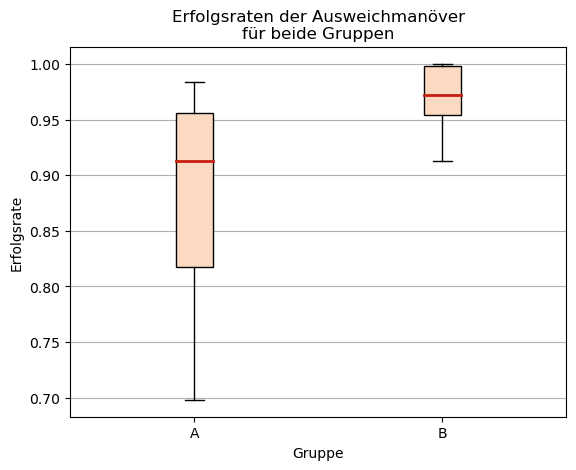

The samples *HAVE NO* equal variances: p = 0.00031134652132134373
The effect size is d = -1.34 (large).


,user,collisions,success_rate
15,B5,3,0.976
16,B6,7,0.944
17,B7,4,0.968
18,B9,1,0.992
19,B11,5,0.960
20,B12,0,1.000
21,B13,6,0.952
22,B14,6,0.952
23,B15,2,0.984
24,B16,0,1.000


In [28]:
collision_dict = {'user':[], 'group':[], 'collisions':[], 'success_rate':[]}

for user in a_result_dict:
    collision_dict['group'].append('A')
    collision_dict['user'].append(user)
    collision_dict['collisions'].append(len(a_result_dict[user]['EndState'].loc[a_result_dict[user]['EndState'] == 'Collision']))
    collision_dict['success_rate'].append(round(1-len(a_result_dict[user]['EndState'].loc[a_result_dict[user]['EndState'] == 'Collision']) / len(a_result_dict[user]['EndState']), 3))

for user in b_result_dict:
    if user == 'B4':
        continue
    collision_dict['group'].append('B')
    collision_dict['user'].append(user) 
    collision_dict['collisions'].append(len(b_result_dict[user]['EndState'].loc[b_result_dict[user]['EndState'] == 'Collision']))
    collision_dict['success_rate'].append(round(1-len(b_result_dict[user]['EndState'].loc[b_result_dict[user]['EndState'] == 'Collision']) / len(b_result_dict[user]['EndState']), 3))

collision_df = pd.DataFrame(collision_dict)
print('Collision percentage per user:')
succesful_users = collision_df['success_rate'].loc[collision_df['success_rate'] > 0.95]
print(f'{len(succesful_users)} out of 30 users ({round(len(succesful_users)*100/30)}%) dodged collisons in 95% of their trials.')

a = collision_df['success_rate'].loc[collision_df['group'] == 'A']
b = collision_df['success_rate'].loc[collision_df['group'] == 'B']
independent_test(a, b, print_results=True)
boxplot([a, b], ['A', 'B'], 'Erfolgsraten der Ausweichmanöver\nfür beide Gruppen', 'Gruppe', 'Erfolgsrate')

# equal variance
_, p_levene = stats.levene(a, b, center= 'mean')
if p_levene > 0.5:
    print(f'The samples {ftxt.GREEN}*HAVE*{ftxt.END} equal variances: p = {p_levene}')
else:
    print(f'The samples {ftxt.RED}*HAVE NO*{ftxt.END} equal variances: p = {p_levene}')

cohens_d(a, b)

collision_df.loc[collision_df['group'] == 'B'].drop('group', axis=1)


***
### Other analyses attempts

#### Data transformation and assumption checks prior to factorial mixed ANOVA in Jamovi

##### General transformations

Trimmed 0 of 3780 values : 0%
Trimming 0.0 quantile at -222.0172
Trimming 1.0 quantile at 287.0553
Trimmed 0 of 3780 values : 0%
39 out of 126 residuals are not normally distributed: 31%
15 out of 126 have no Homoscedacity: 12%
Groups have no Homoscedacity:  stat = 87.3702; p = 1.496984216638574e-20
10 factors are not normal and not homogenous. Factors: ['Sphere_0.3_24_-13', 'Sphere_0.8_24_-27', 'Cylinder_0.8_18_-40', 'Car_0.3_18_40', 'Car_0.3_18_-13', 'Car_0.3_18_-40', 'Car_0.3_30_40', 'Car_0.3_30_-40', 'Car_0.8_24_-27', 'Car_0.8_24_-40']


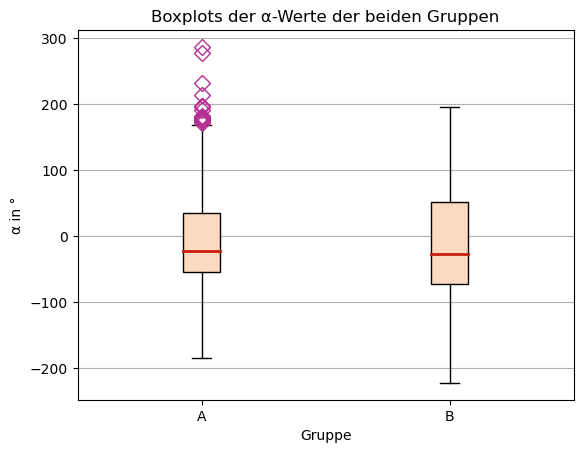

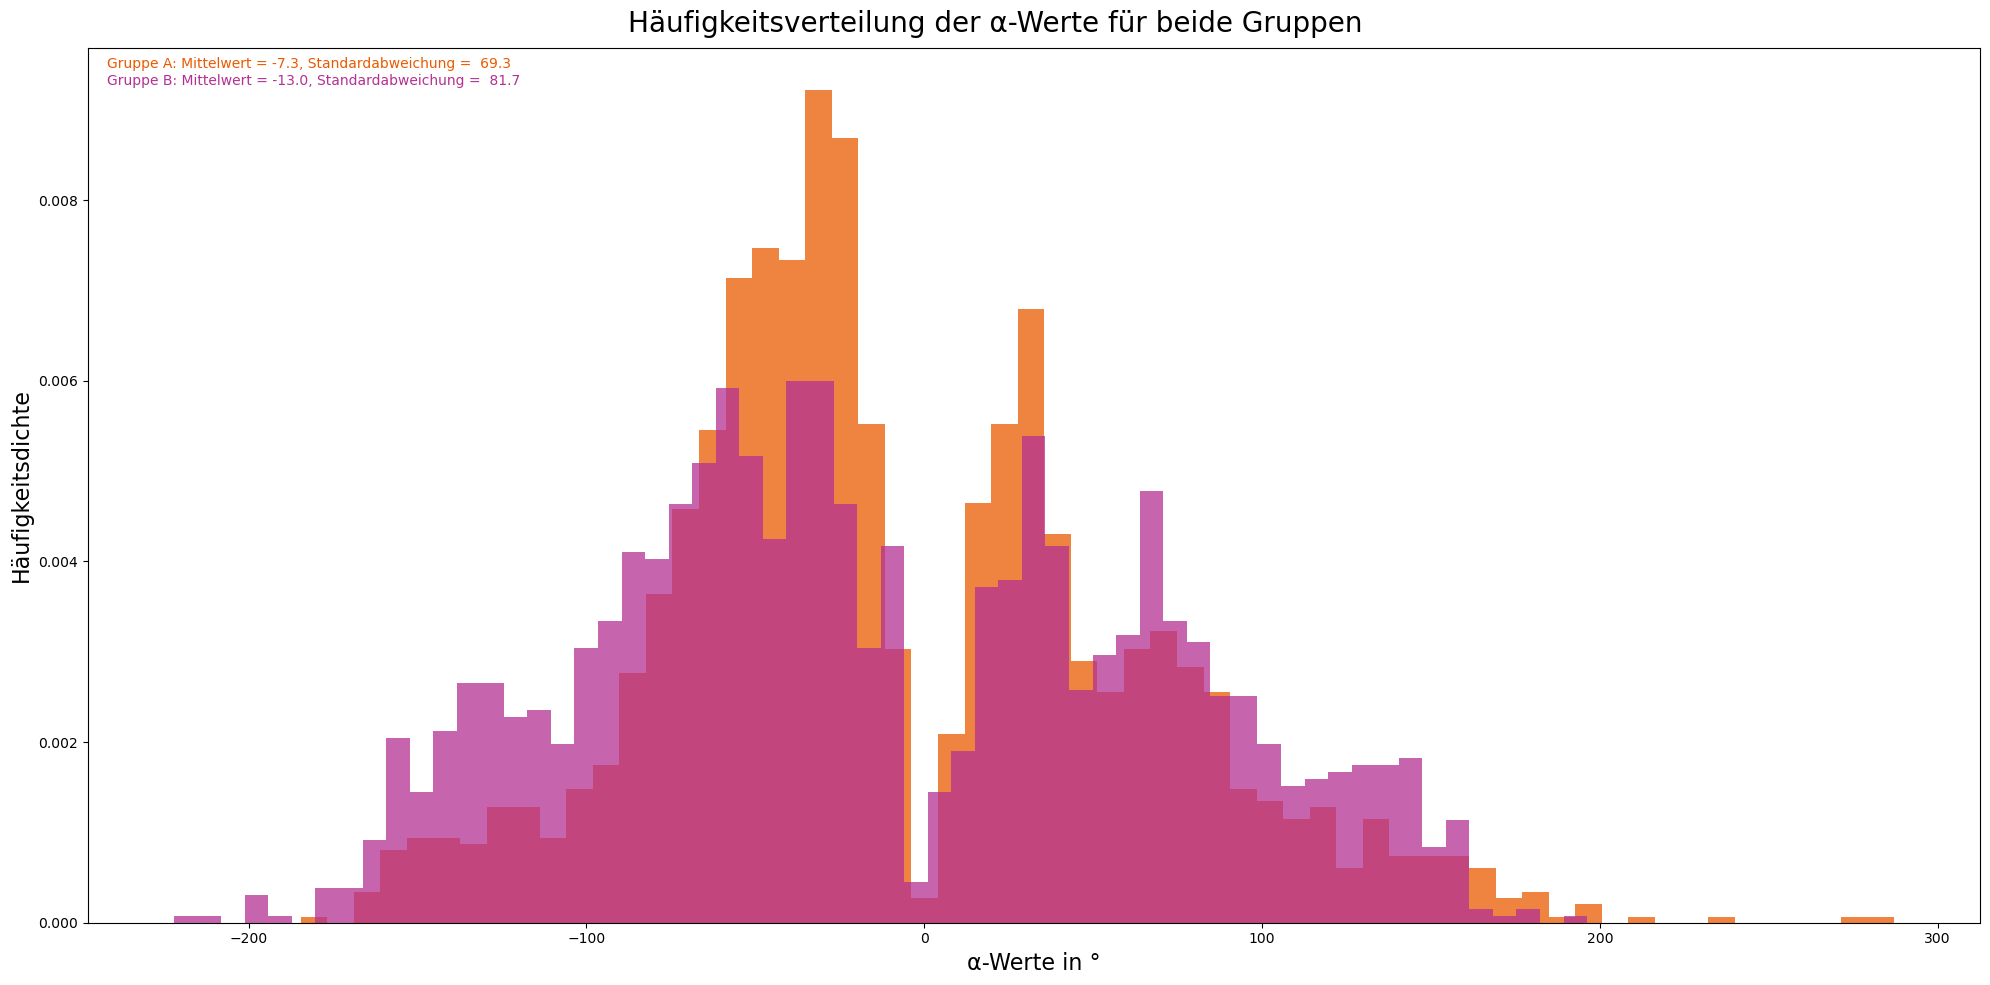

In [29]:
import math
# region data transformation functions
def factorial_mixed_anova_df(winsorize=False, lower_quantile_value=float('-inf'), upper_quantile_value=float('inf'), print_trimmed_tests=False):
    fma_dict = {'testperson': [], 'group': []}
    a, b, = [], []
    trim_count = 0
    all_count = 0

    if winsorize:
        trim_string = 'Winsoriz'
        upper_value = upper_quantile_value
        lower_value = lower_quantile_value
    else:
        trim_string = 'Trimm'
        upper_value = None
        lower_value = None        

    for form_con in form_var.conditions:
        for size_con in size_var.conditions:
            for speed_con in speed_var.conditions:
                for angle_con in angle_var.conditions:
                    fma_dict[f'{form_con}_{size_con}_{speed_con}_{angle_con}'] = []

    for user in a_result_dict:
        fma_dict['testperson'].append(user)
        fma_dict['group'].append('A')
        for i in range(len(a_result_dict[user])):
            form_con = a_result_dict[user].iloc[i]['form']
            size_con = a_result_dict[user].iloc[i]['size']
            speed_con = a_result_dict[user].iloc[i]['speed']
            angle_con = a_result_dict[user].iloc[i]['angle']
            all_count += 1

            dv=transform_data(a_result_dict[user].iloc[i]['max_yaw_virt'])
            
            if(dv > upper_quantile_value):
                if print_trimmed_tests:
                    print(f"{trim_string}ing: user: {user}, test: {form_con}_{size_con}_{speed_con}_{angle_con}, untransformed = {a_result_dict[user].iloc[i]['max_yaw_virt']}, transformed = {dv}")
                fma_dict[f'{form_con}_{size_con}_{speed_con}_{angle_con}'].append((upper_value))
                a.append(upper_value)
                trim_count += 1
                continue

            if(dv < lower_quantile_value):
                if print_trimmed_tests:
                    print(f"{trim_string}ing: user: {user}, test: {form_con}_{size_con}_{speed_con}_{angle_con}, untransformed = {a_result_dict[user].iloc[i]['max_yaw_virt']}, transformed = {dv}")
                fma_dict[f'{form_con}_{size_con}_{speed_con}_{angle_con}'].append((lower_value))
                a.append(lower_value)
                trim_count += 1
                continue
                
            fma_dict[f'{form_con}_{size_con}_{speed_con}_{angle_con}'].append(dv)
            a.append(dv)
        
    for user in b_result_dict:
        fma_dict['testperson'].append(user)
        fma_dict['group'].append('B')
        for i in range(len(b_result_dict[user])):
            form_con = b_result_dict[user].iloc[i]['form']
            size_con = b_result_dict[user].iloc[i]['size']
            speed_con = b_result_dict[user].iloc[i]['speed']
            angle_con = b_result_dict[user].iloc[i]['angle']
            all_count += 1

            dv=transform_data(b_result_dict[user].iloc[i]['max_yaw_real'])

            if(dv > upper_quantile_value):
                if print_trimmed_tests:
                    print(f"{trim_string}ing: user: {user}, test: {form_con}_{size_con}_{speed_con}_{angle_con}, untransformed = {b_result_dict[user].iloc[i]['max_yaw_real']}, transformed = {dv}")
                fma_dict[f'{form_con}_{size_con}_{speed_con}_{angle_con}'].append((upper_value))
                b.append(upper_value)
                trim_count += 1
                continue

            if(dv < lower_quantile_value):
                if print_trimmed_tests:
                    print(f"{trim_string}ing: user: {user}, test: {form_con}_{size_con}_{speed_con}_{angle_con}, untransformed = {b_result_dict[user].iloc[i]['max_yaw_real']}, transformed = {dv}")
                fma_dict[f'{form_con}_{size_con}_{speed_con}_{angle_con}'].append((lower_value))
                b.append(lower_value)
                trim_count += 1
                continue

            fma_dict[f'{form_con}_{size_con}_{speed_con}_{angle_con}'].append(dv)
            b.append(dv)

    print(f'{trim_string}ed {trim_count} of {all_count} values : {round(trim_count / all_count * 100)}%')
    dataframe = pd.DataFrame(fma_dict)
    return dataframe, a, b

def residual_normality(rndf: pd.DataFrame, print_results:bool=False):
    non_normal_factors = []
    for col in rndf.columns.values:
        if col == 'group' or col == 'testperson':
            continue
        
        residuals = rndf[col] - rndf[col].mean()
        stat, p = stats.shapiro(residuals)
        if p < 0.05:
            if(print_results):
                print(f'No residual Normality for {col}: stat = {round(stat,4)}; p = {round(p,4)}')
            non_normal_factors.append(col)
    
    print(f'{len(non_normal_factors)} out of {len(rndf.columns.values) - 2} residuals are not normally distributed: {round(len(non_normal_factors) / (len(rndf.columns.values) - 2) * 100)}%')
    return non_normal_factors

def test_homoscedacity(hdf: pd.DataFrame, print_results:bool=False, center:str='mean', centers_tried=[]):
    non_homogenous_factors = []
    a, b = pd.DataFrame(), pd.DataFrame()

    for col in hdf.columns.values:
        if col == 'group' or col == 'testperson':
            continue

        a = hdf.loc[hdf['group'] == 'A'][col]
        b = hdf.loc[hdf['group'] == 'B'][col]

        stat, p = stats.levene(a, b, center=center)
        if(math.isnan(p) or math.isnan(stat)):
            centers_tried.append(center)
            if('mean' not in centers_tried):
                print(f'{ftxt.RED} center = {center} produces NaN!{ftxt.END}')
                test_homoscedacity(hdf, center = 'mean', centers_tried=centers_tried)
                return
            if('median' not in centers_tried):
                print(f'{ftxt.RED} center = {center} produces NaN!{ftxt.END}')
                test_homoscedacity(hdf, center = 'median', centers_tried=centers_tried)
                return
            if('trimmed' not in centers_tried):
                print(f'{ftxt.RED} center = {center} produces NaN!{ftxt.END}')
                test_homoscedacity(hdf, center = 'trimmed', centers_tried=centers_tried)
                return
            print(f'{ftxt.RED} ALL centers produce NaN{ftxt.END}')
            return
        if p < 0.05:
            non_homogenous_factors.append(col)
            if(print_results):
                print(f'{ftxt.RED}No Homoscedacity for for {col}: {ftxt.END} stat = {round(stat,4)}; p = {p}')
    
    if len(non_homogenous_factors) == 0:
        print(f'{ftxt.GREEN}All groups have Homoscedacity{ftxt.END}')
    else:
        print(f'{ftxt.RED}{len(non_homogenous_factors)}{ftxt.END} out of {len(hdf.columns.values) - 2} have no Homoscedacity: {round(len(non_homogenous_factors) / (len(hdf.columns.values) - 2) * 100)}%')
    return non_homogenous_factors

def group_homoscedacity(ghdf: pd.DataFrame, center:str='mean', centers_tried=[]):
    groups=[]
    a, b = pd.DataFrame(), pd.DataFrame()
    for _, group in ghdf.groupby('group'):
        groups.append(group.iloc[:, 2:])
    
    for col in groups[0]:
        a = pd.concat([a, groups[0][col]], ignore_index=True)
    
    for col in groups[1]:
        b = pd.concat([b, groups[1][col]], ignore_index=True)
    
    stat, p = stats.levene(a[0], b[0], center=center)
    if(math.isnan(p) or math.isnan(stat)):
        centers_tried.append(center)
        if('mean' not in centers_tried):
            print(f'{ftxt.RED} center = {center} produces NaN!{ftxt.END}')
            group_homoscedacity(ghdf, center = 'mean', centers_tried=centers_tried)
            return
        if('median' not in centers_tried):
            print(f'{ftxt.RED} center = {center} produces NaN!{ftxt.END}')
            group_homoscedacity(ghdf, center = 'median', centers_tried=centers_tried)
            return
        if('trimmed' not in centers_tried):
            print(f'{ftxt.RED} center = {center} produces NaN!{ftxt.END}')
            group_homoscedacity(ghdf, center = 'trimmed', centers_tried=centers_tried)
            return
        print(f'{ftxt.RED} ALL centers produce NaN{ftxt.END}')
        return
    if p < 0.05:
        print(f'{ftxt.RED}Groups have no Homoscedacity: {ftxt.END} stat = {round(stat,4)}; p = {p}')
    else:
        print(f'{ftxt.GREEN}Groups have Homoscedacity: {ftxt.END} stat = {round(stat,4)}; p = {round(p,4)}')

def reverse_transformation(data):
    return 1 / (data**2)

def trim_outliers(df: pd.DataFrame, trim_at:float, winsorize:bool=False, print_quantile_values:bool=False, print_trimmed_tests:bool=False):
    lower_quantile = trim_at
    upper_quantile = 1 - trim_at
    qdf = pd.DataFrame()
    for col in df.iloc[:, 2:]:
        qdf = pd.concat([qdf, df.iloc[:, 2:][col]], ignore_index=True)

    quantiles = qdf.quantile([lower_quantile, upper_quantile])

    if(winsorize):
        if print_quantile_values:
            print(f'Winsorizing {lower_quantile} quantile at {quantiles.iloc[0][0]}. Reverse transformed: {reverse_transformation(quantiles.iloc[0][0])}')
            print(f'Winsorizing {upper_quantile} quantile at {quantiles.iloc[1][0]}. Reverse transformed: {reverse_transformation(quantiles.iloc[1][0])}')
        return factorial_mixed_anova_df(lower_quantile_value=quantiles.iloc[0][0], upper_quantile_value=quantiles.iloc[1][0], winsorize=True, print_trimmed_tests=print_trimmed_tests)
    else:
        if print_quantile_values:
            print(f'Trimming {lower_quantile} quantile at {quantiles.iloc[0][0]}')
            print(f'Trimming {upper_quantile} quantile at {quantiles.iloc[1][0]}')
        return factorial_mixed_anova_df(lower_quantile_value=quantiles.iloc[0][0], upper_quantile_value=quantiles.iloc[1][0], winsorize=False, print_trimmed_tests=print_trimmed_tests)

# endregion

def transform_data(data):
    return (((data)))

#trim 7% of data: trim_at = 0.0331, math.log((abs(data)
#trim 0% of data: trim_at = 0.0, math.log((abs(data)
#trim 0% of data: trim_at = 0.0, math.sqrt(((abs(1/data))))
fma_df, _, _ = factorial_mixed_anova_df()
trimmed_df, a, b = trim_outliers(fma_df, 0.000, winsorize=False, print_quantile_values=True, print_trimmed_tests=True)
#trimmed_df.to_csv('VR-Dodge-Study-Data-for-Jamovi.csv')
center = 'mean'
non_normal_factors = residual_normality(trimmed_df, print_results=False)
non_homogenous_factors = test_homoscedacity(trimmed_df, center=center, print_results=False)
group_homoscedacity(trimmed_df,center=center)

non_factors = []
for factor in non_normal_factors:
    if factor in non_homogenous_factors:
        non_factors.append(factor)

print(f'{len(non_factors)} factors are not normal and not homogenous. Factors: {non_factors}')

boxplot([a, b], value_names=['A', 'B'], title='Boxplots der α-Werte der beiden Gruppen', xlabel='Gruppe', ylabel='α in °')
#plot_test_data(a, b, show_probability_plot=True, show_histogram=False, bins = 60, print_both=True, )
plot_test_data(a, b, title='Häufigkeitsverteilung der α-Werte für beide Gruppen', x_label_histogram="α-Werte in °", show_probability_plot=False, show_histogram=True, bins = 60, print_both=False)

##### BoxCox transformation of all data

Trimmed 0 of 3780 values : 0%
Winsorizing 0.0001 quantile at -217.01712952. Reverse transformed: 2.1233029856892923e-05
Winsorizing 0.9999 quantile at 283.7514336699964. Reverse transformed: 1.2420065065200442e-05
Winsorizing: user: A23, test: Cylinder_0.8_24_0, untransformed = 287.0553, transformed = 287.0553
Winsorizing: user: B4, test: Sphere_0.8_18_27, untransformed = -222.0172, transformed = -222.0172
Winsorized 2 of 3780 values : 0%
28 out of 126 residuals are not normally distributed: 22%
6 out of 126 have no Homoscedacity: 5%
Groups have no Homoscedacity:  stat = 12.7384; p = 0.00036317186499126457
3 factors are not normal and not homogenous. Factors: ['Sphere_0.8_30_40', 'Sphere_0.8_30_13', 'Car_0.8_24_-40']


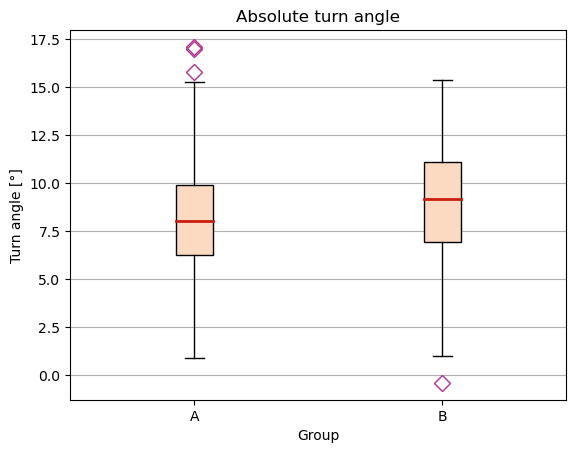

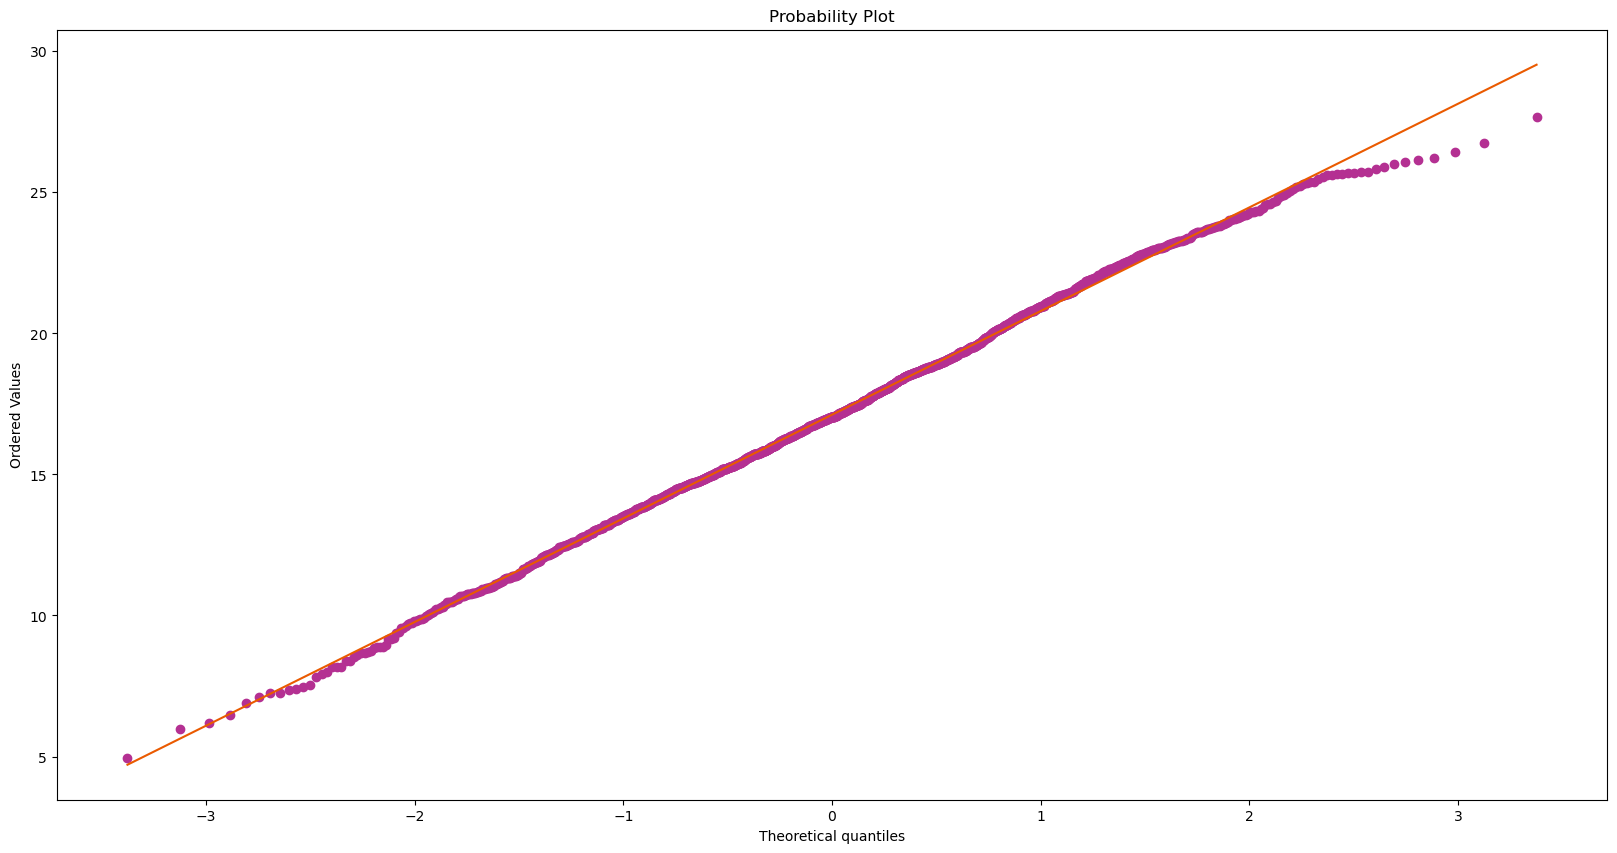

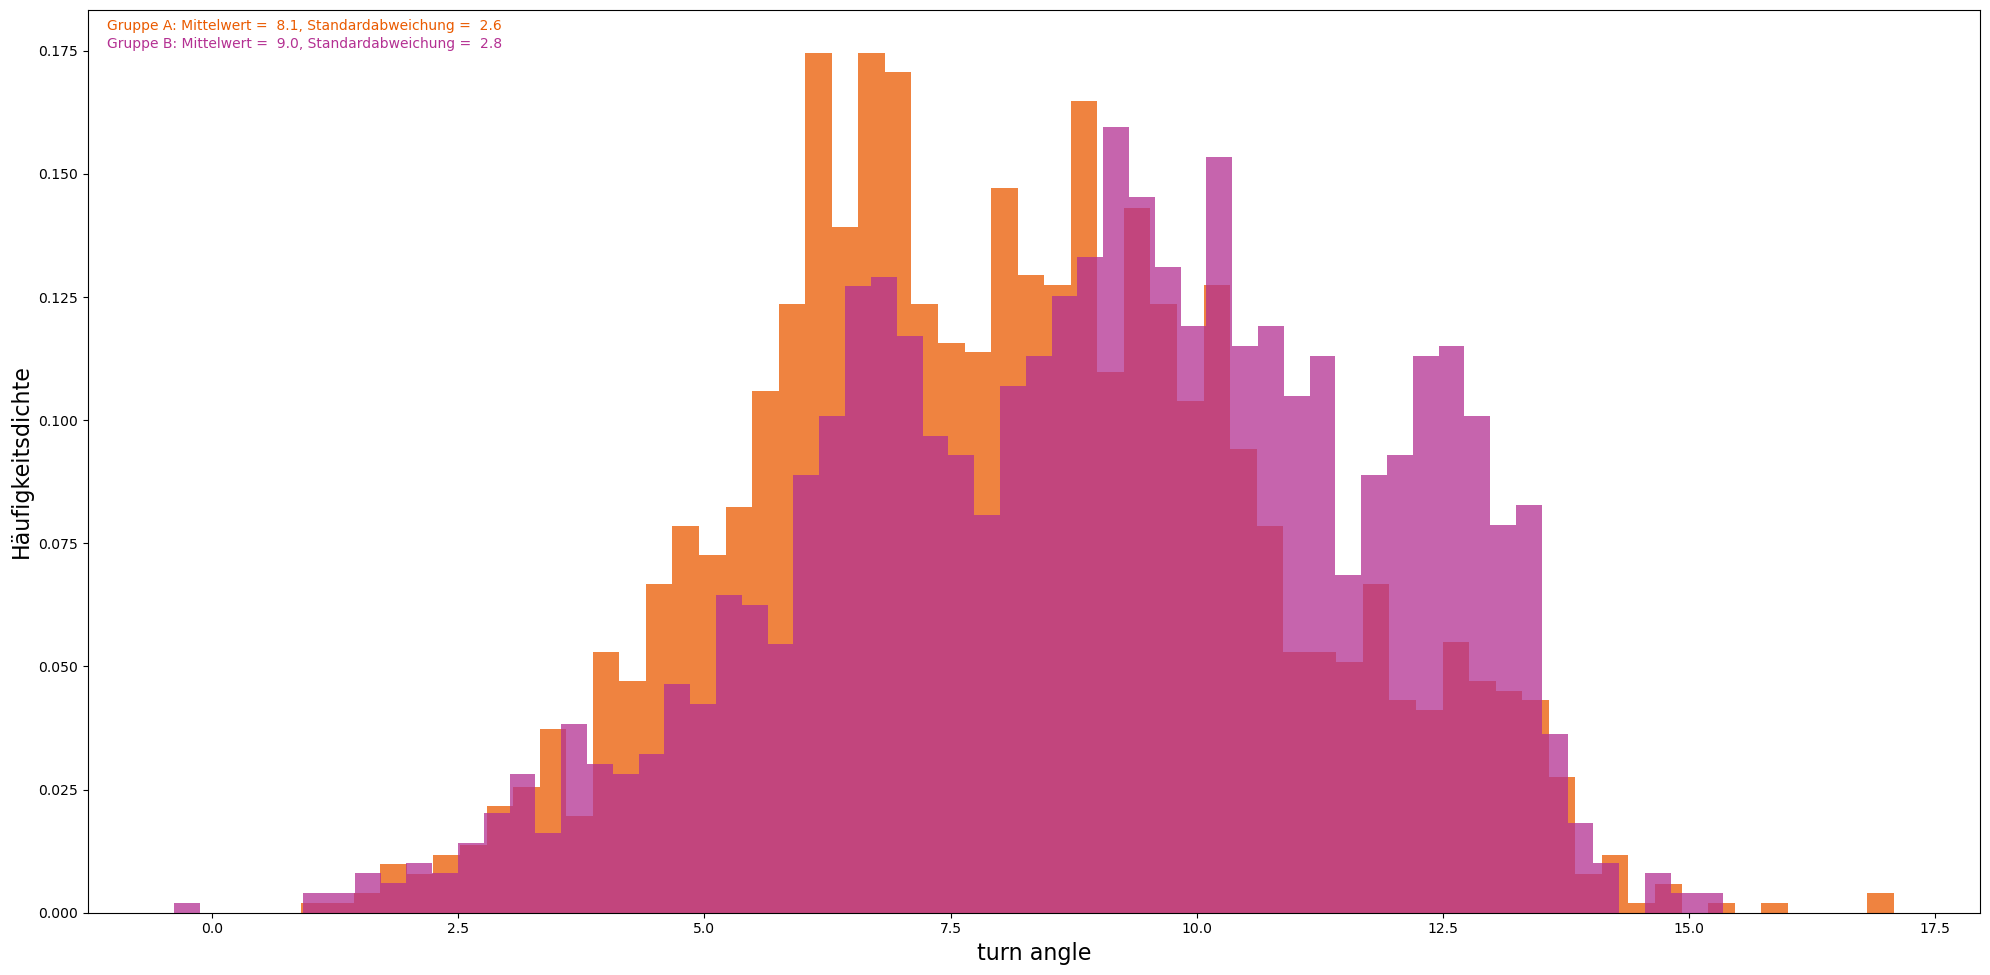

In [30]:
import scipy.stats as stats

fma_df, _, _ = factorial_mixed_anova_df(print_trimmed_tests=False)
trimmed_df, a, b = trim_outliers(fma_df, 0.0001, winsorize=True, print_quantile_values=True, print_trimmed_tests=True)
center = 'trimmed'

# region Boxcox transformation
# Stack the data
fma_stacked = (trimmed_df.T.iloc[2:, :].stack([0]).astype('float'))

# Apply boxcox transformation to the stacked data again
fma_stacked_boxcox = pd.Series(stats.boxcox(abs(fma_stacked))[0], index=fma_stacked.index)

# Unstack the data
fma_unstacked = fma_stacked_boxcox.unstack([0])

# Reorder the columns to match the original dataframe
fma_unstacked = fma_unstacked[fma_df.iloc[:, 2:].columns]
fma_unstacked['testperson'] = fma_df['testperson']
fma_unstacked['group'] = fma_df['group']

# endregion

# region assumption tests
a, b = pd.DataFrame(), pd.DataFrame()
groups=[]
for _, group in fma_unstacked.groupby('group'):
    groups.append(group.iloc[:, :-2])

groups[0]

for col in groups[0]:
    a = pd.concat([a, groups[0][col]], ignore_index=True)

for col in groups[1]:
    b = pd.concat([b, groups[1][col]], ignore_index=True)

non_normal_factors = residual_normality(fma_unstacked, print_results=False)
non_homogenous_factors = test_homoscedacity(fma_unstacked, center=center, print_results=False)
stat, p = stats.levene(a[0], b[0], center=center)
if(math.isnan(p) or math.isnan(stat)) and center != 'trimmed':
    print(f'{ftxt.RED} center = {center} produces NaN!{ftxt.END}')
    center = 'trimmed'
    stat, p = stats.levene(a[0], b[0], center='trimmed')
if(math.isnan(p) or math.isnan(stat)) and center != 'mean':
    print(f'{ftxt.RED} center = {center} produces NaN!{ftxt.END}')
    center = 'mean'
    stat, p = stats.levene(a[0], b[0], center='mean')
if(math.isnan(p) or math.isnan(stat)) and center != 'median':
    print(f'{ftxt.RED} center = {center} produces NaN!{ftxt.END}')
    center = 'median'
    stat, p = stats.levene(a[0], b[0], center='median')
if p < 0.05:
    print(f'{ftxt.RED}Groups have no Homoscedacity: {ftxt.END} stat = {round(stat,4)}; p = {p}')
else:
    print(f'{ftxt.GREEN}Groups have Homoscedacity: {ftxt.END} stat = {round(stat,4)}; p = {round(p,4)}')

non_factors = []
for factor in non_normal_factors:
    if factor in non_homogenous_factors:
        non_factors.append(factor)

print(f'{len(non_factors)} factors are not normal and not homogenous. Factors: {non_factors}')

# endregion

boxplot([a[0].values, b[0].values], value_names=['A', 'B'], title='Absolute turn angle', xlabel='Group', ylabel='Turn angle [°]')
plot_test_data(a[0].values, b[0].values, x_label_histogram="turn angle", show_probability_plot=True, show_histogram=False, bins = 60, print_both=True)
plot_test_data(a[0].values, b[0].values, x_label_histogram="turn angle", show_probability_plot=False, show_histogram=True, bins = 60, print_both=False)

##### BoxCox transformation of each measrurement

Trimmed 0 of 3780 values : 0%
Winsorizing 0.0 quantile at -222.0172. Reverse transformed: 2.0287417073522106e-05
Winsorizing 1.0 quantile at 287.0553. Reverse transformed: 1.213581256902311e-05
Winsorized 0 of 3780 values : 0%
Winsorizing 0.0 quantile at -0.3523439024232741. Reverse transformed: 8.055017342407947
Winsorizing 1.0 quantile at 64.82295942571771. Reverse transformed: 0.0002379810033204878
Winsorized 2922 of 3780 values : 77%
126 out of 126 residuals are not normally distributed: 100%
6 out of 126 have no Homoscedacity: 5%
Groups have no Homoscedacity:  stat = 42.5598; p = 7.764569326298172e-11


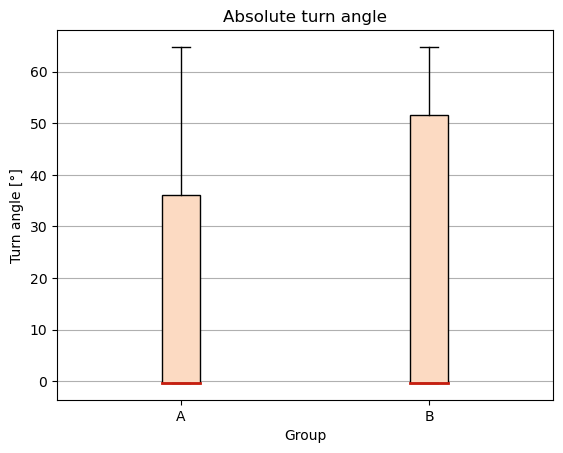

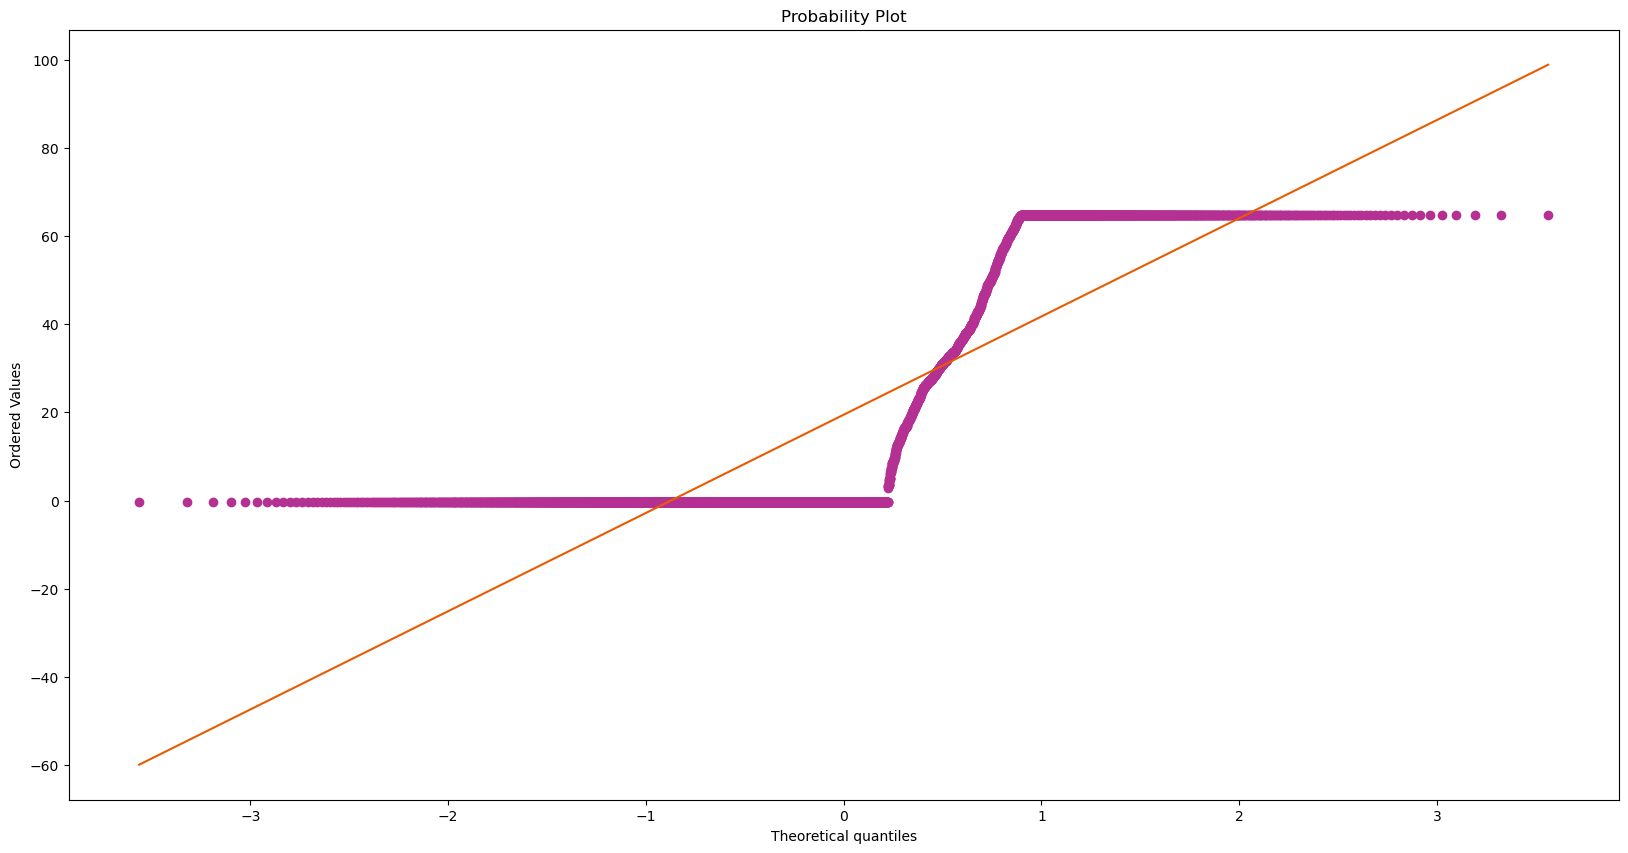

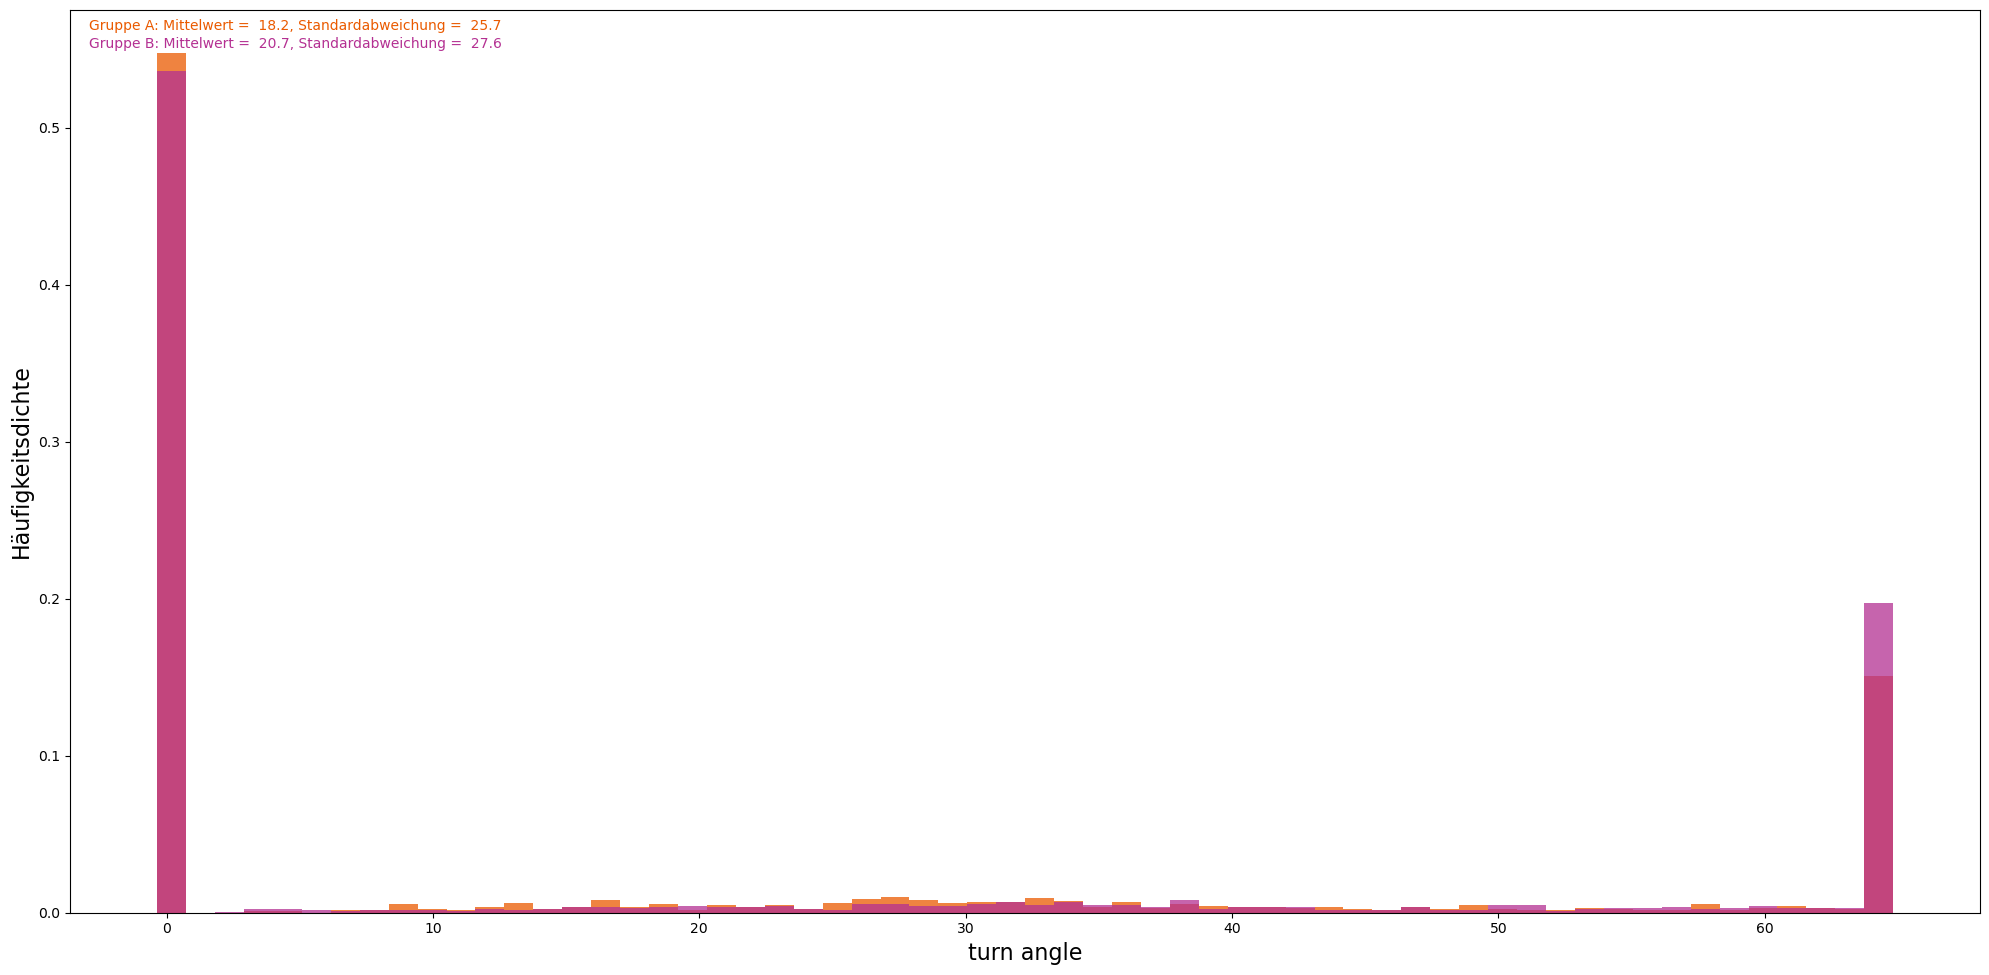

In [31]:
def box_cox_transformations(bxdf: pd.DataFrame):
    for col in bxdf.columns.values:
        if col == 'group' or col == 'testperson':
            continue
        bxdf[col], _ = stats.boxcox(abs(bxdf[col]))
    return bxdf

fma_df, _, _ = factorial_mixed_anova_df(print_trimmed_tests=False)
trimmed_df, _, _ = trim_outliers(fma_df, 0.000, winsorize=True, print_quantile_values=True, print_trimmed_tests=True)
center = 'mean'
ageläks = box_cox_transformations(trimmed_df)
box_coxed_df, a, b = trim_outliers(ageläks, 0.000, winsorize=True, print_quantile_values=True, print_trimmed_tests=False)

non_normal_factors = residual_normality(box_coxed_df, print_results=False)
non_homogenous_factors = test_homoscedacity(fma_unstacked, center=center)
group_homoscedacity(box_coxed_df, center=center)

boxplot([a, b], value_names=['A', 'B'], title='Absolute turn angle', xlabel='Group', ylabel='Turn angle [°]')
plot_test_data(a, b, x_label_histogram="turn angle", show_probability_plot=True, show_histogram=False, bins = 60, print_both=True)
plot_test_data(a, b, x_label_histogram="turn angle", show_probability_plot=False, show_histogram=True, bins = 60, print_both=False)

***
#### Alternative Methods to mixed ANOVA

##### 1-way mixed ANOVAs

In [32]:
def mixed_anova_df(within: variable):
    dependent_var = 'alpha_value'
    a_values, b_values = [], []

    pingu_dict = {dependent_var: [], within.name: [], 'testperson': [], 'group': [], 'factor_comb': []}

    for user in a_result_dict:
        for i in range(len(a_result_dict[user])):
            pingu_dict[dependent_var].append(a_result_dict[user].iloc[i]['max_yaw_virt'])
            a_values.append(a_result_dict[user].iloc[i]['max_yaw_virt'])
            pingu_dict[within.name].append(a_result_dict[user].iloc[i][within.name])
            pingu_dict['testperson'].append(user)
            pingu_dict['group'].append('A')
            pingu_dict['factor_comb'].append(f'A_{a_result_dict[user].iloc[i][within.name]}')
        
    for user in b_result_dict:
        for i in range(len(b_result_dict[user])):
            pingu_dict[dependent_var].append(b_result_dict[user].iloc[i]['max_yaw_real'])
            b_values.append(b_result_dict[user].iloc[i]['max_yaw_real'])
            pingu_dict[within.name].append(b_result_dict[user].iloc[i][within.name])
            pingu_dict['testperson'].append(user)
            pingu_dict['group'].append('B')
            pingu_dict['factor_comb'].append(f'B_{b_result_dict[user].iloc[i][within.name]}')

    pingu_df = pd.DataFrame(pingu_dict)
    return pingu_df, a_values, b_values

var = form_var
df, a, b = mixed_anova_df(var)

residuals = []
# Use the Shapiro-Wilk test to test for normality in each group
for name, group in df.groupby('group'):
    # Take the logarithm of the data
    # group_A_log = np.sqrt(group['alpha_value'])
    # print(group_A_log)

    # # Calculate the skewness of the transformed data
    # skewness = stats.skew(group_A_log)

    # # Print the skewness of the transformed data
    # # skewness = stats.skew(group['alpha_value'])
    # print("Skewness:", skewness)
    residuals.append(group['alpha_value'] - group['alpha_value'].mean())

W, p = stats.shapiro(residuals)
print(f"Shapiro-Wilk test for residual normality: W = {W}, p = {p}")

print('Sphericity: ', pg.sphericity(df, dv='alpha_value', within=var.name, subject='testperson'))
pg.mixed_anova(df, dv='alpha_value', within=var.name, between='group', subject='testperson')
#pg.normality(df, dv='alpha_value', group='factor_comb')



Shapiro-Wilk test for residual normality: W = 0.9864940643310547, p = 1.5065420850888745e-18
Sphericity:  SpherResults(spher=True, W=0.9847370947824537, chi2=0.43065630403195715, dof=2, pval=0.8062768153987144)


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,725.981361,1,28,725.981361,0.378519,0.543365,0.013338,NaN
1,form,221.096328,2,56,110.548164,0.681845,0.509831,0.023773,0.984967
2,Interaction,455.475977,2,56,227.737988,1.404654,0.253965,0.047770,NaN


##### Ordinary least squares regression / gewöhnliche Methode der kleinsten Quadrate

                            OLS Regression Results                            
Dep. Variable:            alpha_value   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     26.79
Date:                Sun, 26 Feb 2023   Prob (F-statistic):           6.23e-59
Time:                        09:44:42   Log-Likelihood:                -21570.
No. Observations:                3780   AIC:                         4.317e+04
Df Residuals:                    3767   BIC:                         4.325e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -26.29

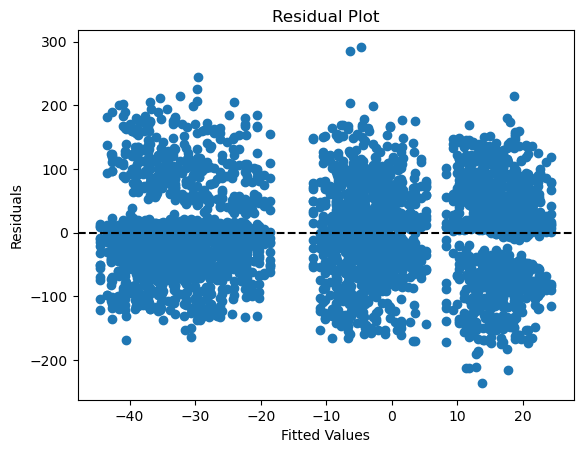

In [33]:
import statsmodels.formula.api as smf

a_values, b_values = [], []
manova_dict = {'alpha_value': [], 'form': [], 'size': [], 'speed': [], 'angle': [], 'testperson': [], 'group': []}

for user in a_result_dict:
    for i in range(len(a_result_dict[user])):
        manova_dict['alpha_value'].append(a_result_dict[user].iloc[i]['max_yaw_virt'])
        a_values.append(a_result_dict[user].iloc[i]['max_yaw_virt'])
        manova_dict['form'].append(a_result_dict[user].iloc[i]['form'])
        manova_dict['size'].append(a_result_dict[user].iloc[i]['size'])
        manova_dict['speed'].append(a_result_dict[user].iloc[i]['speed'])
        manova_dict['angle'].append(a_result_dict[user].iloc[i]['angle'])
        manova_dict['testperson'].append(user)
        manova_dict['group'].append('A')
    
for user in b_result_dict:
    for i in range(len(b_result_dict[user])):
        manova_dict['alpha_value'].append(b_result_dict[user].iloc[i]['max_yaw_real'])
        b_values.append(b_result_dict[user].iloc[i]['max_yaw_real'])
        manova_dict['form'].append(b_result_dict[user].iloc[i]['form'])
        manova_dict['size'].append(b_result_dict[user].iloc[i]['size'])
        manova_dict['speed'].append(b_result_dict[user].iloc[i]['speed'])
        manova_dict['angle'].append(b_result_dict[user].iloc[i]['angle'])
        manova_dict['testperson'].append(user)
        manova_dict['group'].append('B')

df = pd.DataFrame(manova_dict)

dummies = pd.get_dummies(df['form'], prefix='form')
df = pd.concat([df, dummies], axis=1)
formula = 'alpha_value ~ group + C(size) + C(speed) + C(angle) + C(form_Cylinder) + C(form_Sphere) + C(form_Car)'

model = smf.ols(formula, data=df).fit()
print(model.summary())

residuals = model.resid
fitted_values = model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [34]:
#region failed attempt to use OLS
ols_dict = {"dv": [], 'subject': [], 'group': [], 'form': [], 'size': [], 'speed': [], 'angle': []}
a_values, b_values = [], []

for user in a_result_dict:
    for i in range(len(a_result_dict[user])):
        ols_dict['dv'].append(a_result_dict[user].iloc[i]['max_yaw_virt'])
        a_values.append(a_result_dict[user].iloc[i]['max_yaw_virt'])
        ols_dict['subject'].append(user)
        ols_dict['group'].append('A')
        ols_dict['form'].append(f'A_{a_result_dict[user].iloc[i]["form"]}')
        ols_dict['size'].append(f'A_{a_result_dict[user].iloc[i]["size"]}')
        ols_dict['speed'].append(f'A_{a_result_dict[user].iloc[i]["speed"]}')
        ols_dict['angle'].append(f'A_{a_result_dict[user].iloc[i]["angle"]}')
    
for user in b_result_dict:
    for i in range(len(b_result_dict[user])):
        ols_dict['dv'].append(b_result_dict[user].iloc[i]['max_yaw_real'])
        b_values.append(b_result_dict[user].iloc[i]['max_yaw_real'])
        ols_dict['subject'].append(user)
        ols_dict['group'].append('A')
        ols_dict['form'].append(f'A_{b_result_dict[user].iloc[i]["form"]}')
        ols_dict['size'].append(f'A_{b_result_dict[user].iloc[i]["size"]}')
        ols_dict['speed'].append(f'A_{b_result_dict[user].iloc[i]["speed"]}')
        ols_dict['angle'].append(f'A_{b_result_dict[user].iloc[i]["angle"]}')

df = pd.DataFrame(ols_dict)

import statsmodels.formula.api as smf
# Fit mixed ANOVA model
# model = smf.mixedlm("dv ~ group + (form + size + speed + angle) + (form + size + speed + angle | subject)", data=df, groups=df["subject"])
# result = model.fit()

# # Print summary of results
# print(result.summary())

def print_ols_results(var:variable):
    df, a, b = mixed_anova_df(var)

    # Replace with your data
    alpha_values = (df['alpha_value'])
    group = df['group']
    var_vals = df[var.name]

    # Create a dataframe with the variables
    data = pd.DataFrame({"alpha_values": alpha_values, "group": group, var.name: var_vals})

    # Define the model formula
    formula = f"alpha_values ~ group * C({var.name}) + group * C({var.name})"

    # Fit the model
    model = smf.OLS.from_formula(formula, data)
    results = model.fit()

    # Print the summary of the results
    print(results.summary())
    return results

# endregion


#### first attemps with t-tests

##### H01: There are no significant differences in the REAL max yaw yalues of Group B and the VIRTUAL max yaw values of Group A for a specific trial.

H0: There are no significant differences in the REAL max yaw yalues of Group B and the VIRTUAL max yaw values of Group A for a specific trial.
The effect size is d = 0.8161 (large).
The effect size is d = -0.851 (large).
The effect size is d = 0.9223 (large).
The effect size is d = 0.8393 (large).
The effect size is d = -1.0939 (large).
The effect size is d = 0.5396 (medium).
The effect size is d = 1.027 (large).


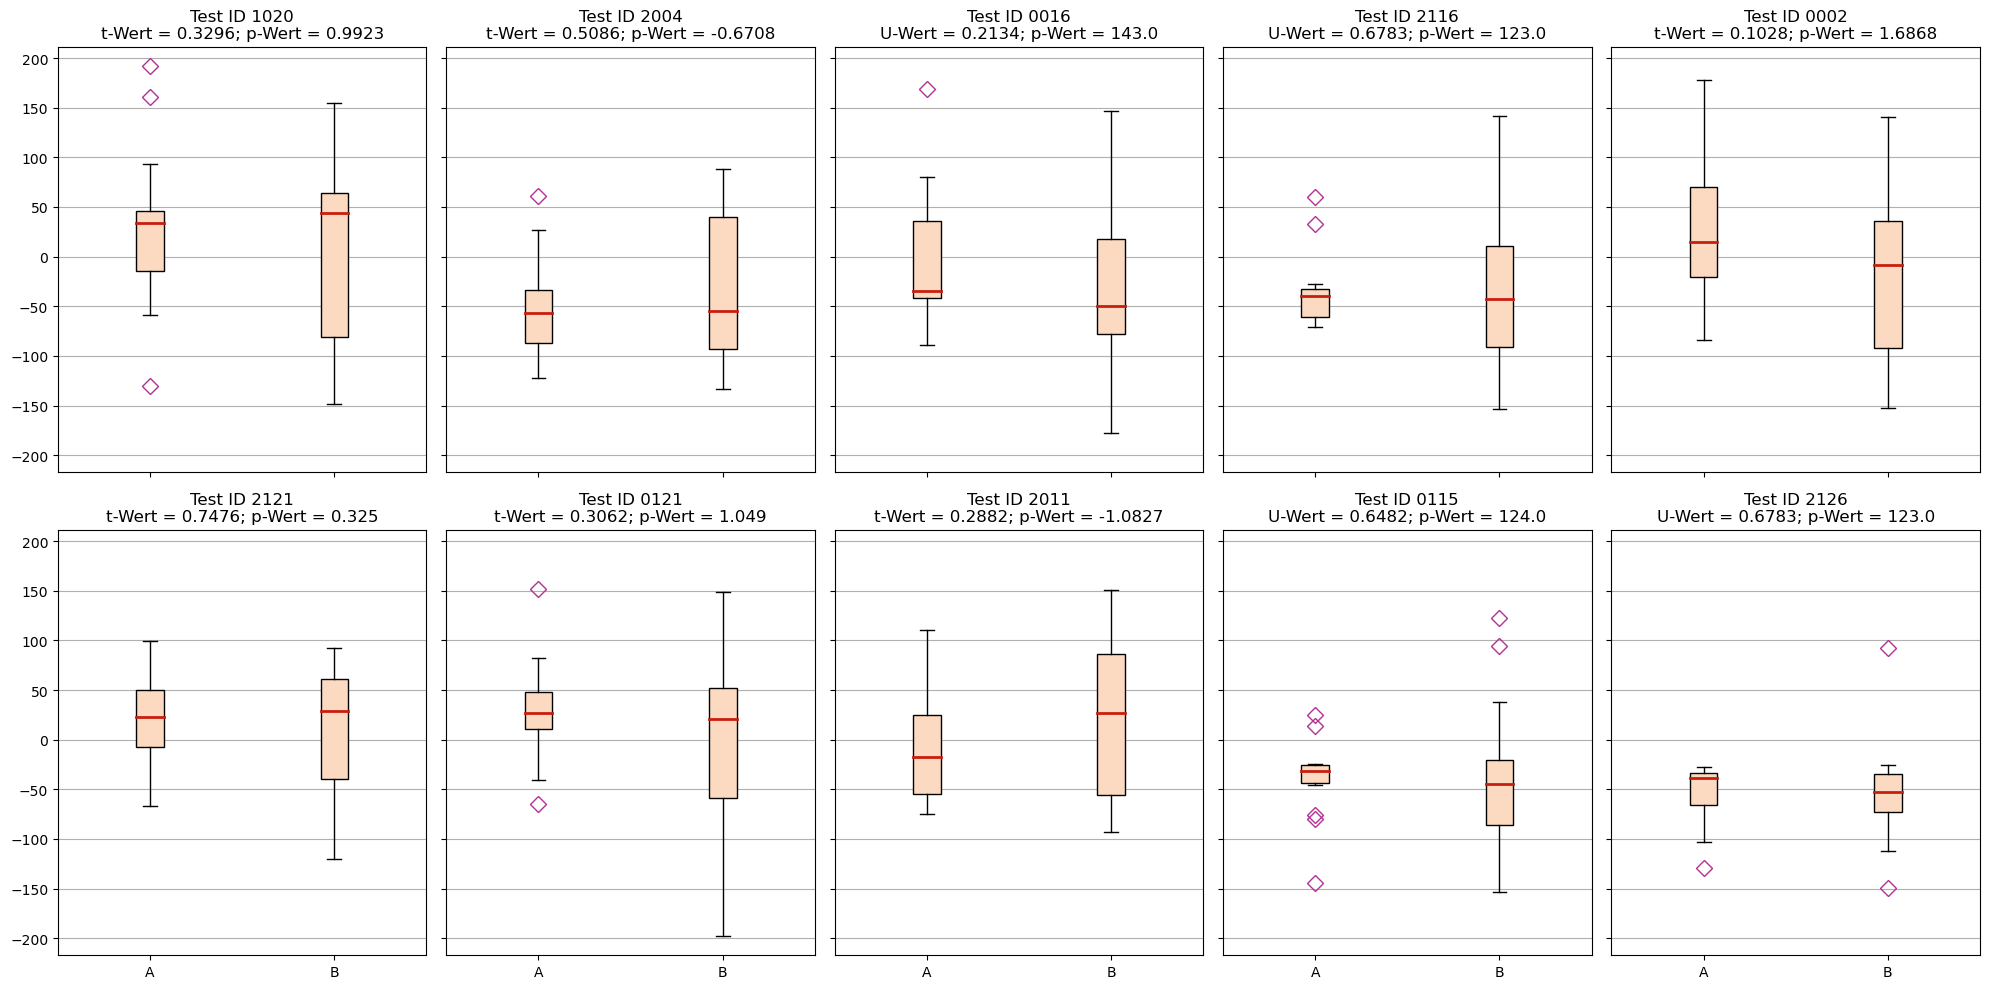

94.44444444444444 % of 126 tested trials show no significant difference between Group A and B
The 7 significant trials are: ['1126', '1010', '1016', '2024', '1021', '0116', '0015']


In [35]:
print(f'H0: There are no significant differences in the REAL max yaw yalues of Group B and the VIRTUAL max yaw values of Group A for a specific trial.')
hypothesis_counter = 0
significant_trials = []

rows, plots_per_row = 2, 5
fig, axs = plt.subplots(rows, plots_per_row, figsize=(20, 10))
i, j = 0, 0
fromm, to =30, 40

for trial_id in trial_id_list:
    a = pd.Series(a_yaws_by_trial[f'{trial_id}'])
    b = pd.Series(b_yaws_by_trial[f'{trial_id}'])

    #print(f'Trial {trial_id}:')
    hypothesis, t, p, method = independent_test(a, b)#, print_results=True)
    #print()

    if hypothesis:
        hypothesis_counter += 1

        if(hypothesis_counter >= fromm and hypothesis_counter < to):
            if(i < rows):
                subboxplot(axs[i][j], [a, b], title=f'Test ID {trial_id}\n{method} = {t.round(4)}; p-Wert = {p.round(4)}')#, ylabel='α-Wert', xlabel=f't-Wert = {t.round(4)}; p-Wert = {p.round(4)}')
            axs[i][j].sharey(axs[0][0])
            j += 1
            if j == plots_per_row:
                i += 1
                j = 0
    else:
        significant_trials.append(trial_id)

#fig.suptitle('Boxplots der α-Werte für die 15 Tests mit signifikanten Gruppenunterschieden', fontsize=15)
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
plt.show()

print(f'{hypothesis_counter/len(trial_id_list)*100} % of {len(trial_id_list)} tested trials show no significant difference between Group A and B')
print(f'The {len(significant_trials)} significant trials are: {significant_trials}')

The effect size is d = 0.8161 (large).
The effect size is d = -0.851 (large).
The effect size is d = 0.9223 (large).
The effect size is d = 0.8393 (large).
The effect size is d = -1.0939 (large).
The effect size is d = 0.5396 (medium).
The effect size is d = 1.027 (large).


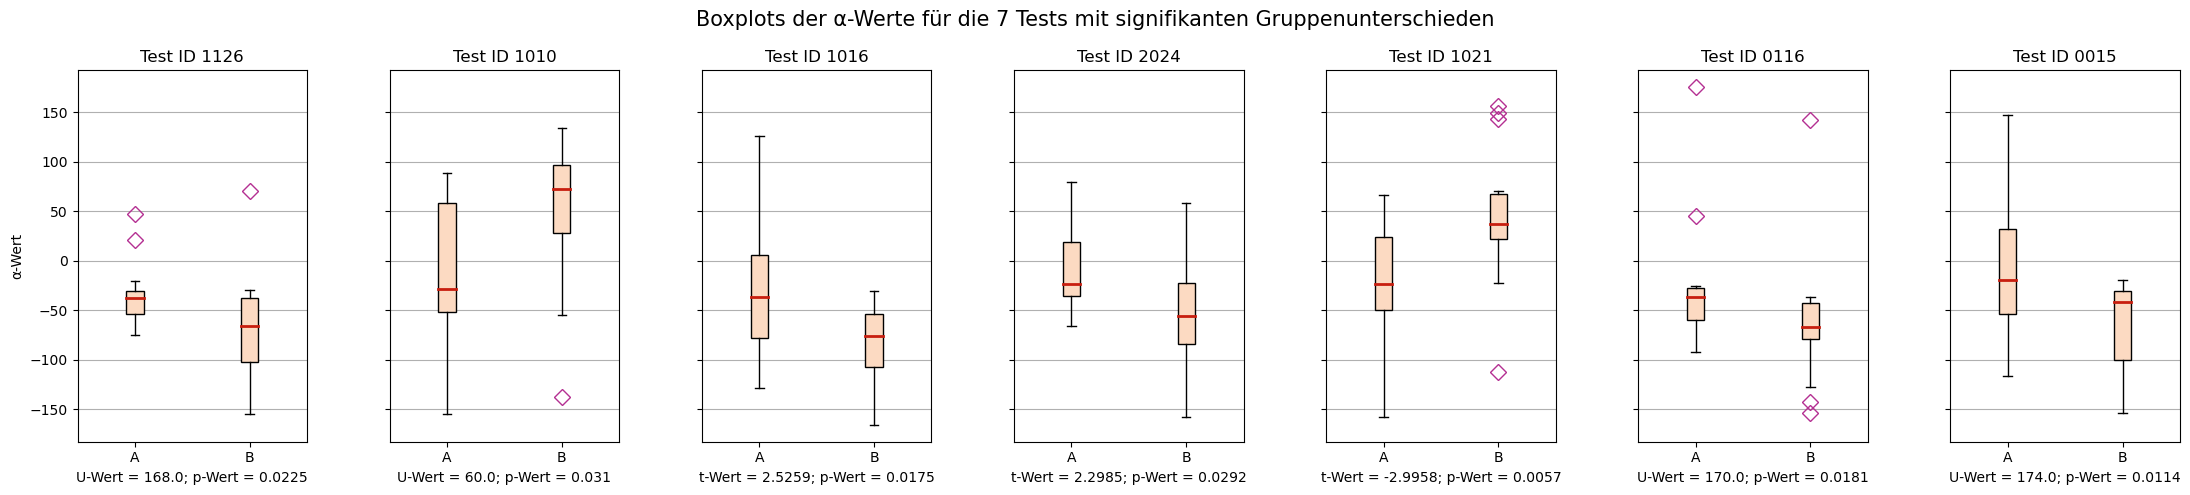

In [36]:
rows, plots_per_row = 1, 7
fig, axs = plt.subplots(rows, plots_per_row, figsize=(22, 5))
i, j = 0, 0

for trial_id in ['1126', '1010', '1016', '2024', '1021', '0116', '0015']:
    a = pd.Series(a_yaws_by_trial[f'{trial_id}'])
    b = pd.Series(b_yaws_by_trial[f'{trial_id}'])

    #print(f'Trial {trial_id}:')
    hypothesis, p, t, method = independent_test(a, b)#, print_results=True)
    #print()
    #subboxplot(axs[i][j], [a, b], title=f'Test ID {trial_id}\n{method} = {t.round(4)}; p-Wert = {p.round(4)}')#, ylabel='α-Wert', xlabel=f'{g_method} = {t.round(4)}; p-Wert = {p.round(4)}')
    #axs[i][j].sharey(axs[0][0])
    subboxplot(axs[j], [a, b], title=f'Test ID {trial_id}', ylabel='α-Wert', xlabel=f'{method} = {t.round(4)}; p-Wert = {p.round(4)}')    
    axs[j].sharey(axs[0])
    j += 1
    if j == plots_per_row:
        i += 1
        j = 0

fig.suptitle(f'Boxplots der α-Werte für die {len(significant_trials)} Tests mit signifikanten Gruppenunterschieden', fontsize=15)    
fig.tight_layout()
for ax in axs.flat:
    ax.label_outer()

plt.show()

##### H04: Größere Objekte rufen beim Ausweichen eine größere Kopfrotation hervor, als kleinere Objekte. 

The effect size is d = -0.8063 (large).
The effect size is d = -0.8284 (large).
96.82539682539682 % of 63 tested trials show no significant difference between size 0.3 and 0.8
The 2 significant trials are: ['111', '203']


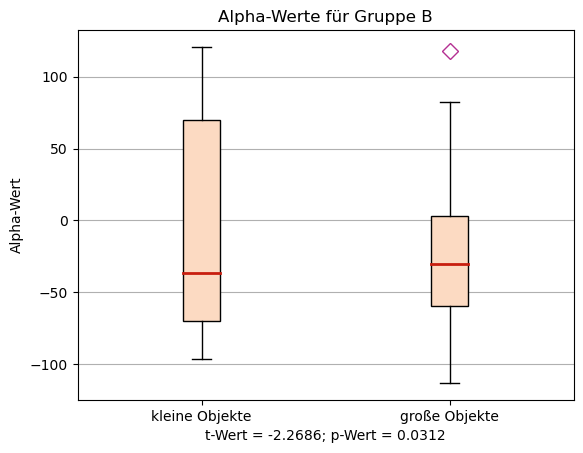

In [37]:
hypothesis_counter = 0
significant_trials = []

a_sizes, b_sizes = get_grouped_samples_for_key_by_variable(size_var, 'max_yaw_virt', 'max_yaw_real')

for id in no_size_ids:
    a = pd.Series(b_sizes[0][f'{id}'])
    b = pd.Series(b_sizes[1][f'{id}'])

    #print(f'Trial {id}:')
    hypothesis, p, t, method = independent_test(a, b)#, print_results=True)
    #print()

    if hypothesis:
        hypothesis_counter += 1
    else:
        significant_trials.append(id)
        # print(f'Trial {id}:')
        # plot_test_data(a, b)

# print(f'{(len(trial_id_list)-assumption_counter)/len(trial_id_list)*100} % of {len(trial_id_list)} trials can not be tested with the t-Test')
# print(f'The {len(false_assumption_trials)} untestable trials are: {false_assumption_trials}')
print(f'{hypothesis_counter/len(no_size_ids)*100} % of {len(no_size_ids)} tested trials show no significant difference between size 0.3 and 0.8')
print(f'The {len(significant_trials)} significant trials are: {significant_trials}')
a_sums = get_samples_for_key_by_variable('A', size_var, 'sum_injected_rotation_g_r(IN DEGREES)')
boxplot([list(b_sizes[0].values())[0], list(b_sizes[1].values())[0]], title='Alpha-Werte für Gruppe B', xlabel=f'{method} = {t.round(4)}; p-Wert = {p.round(4)}', ylabel='Alpha-Wert', value_names=['kleine Objekte', 'große Objekte'])


***
### Exploration

Visualisierungen der Ausweichpfade wurden mit Photoshop erstellt.

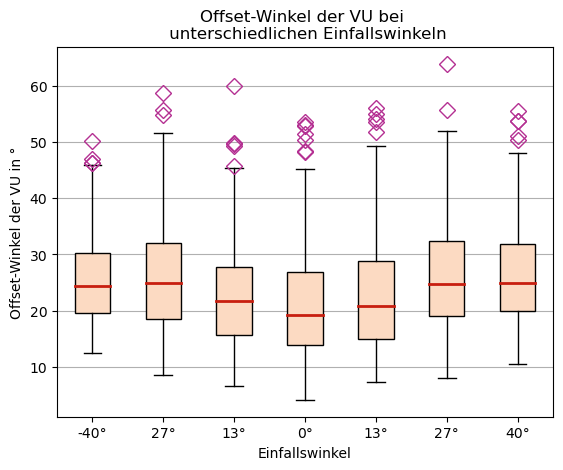

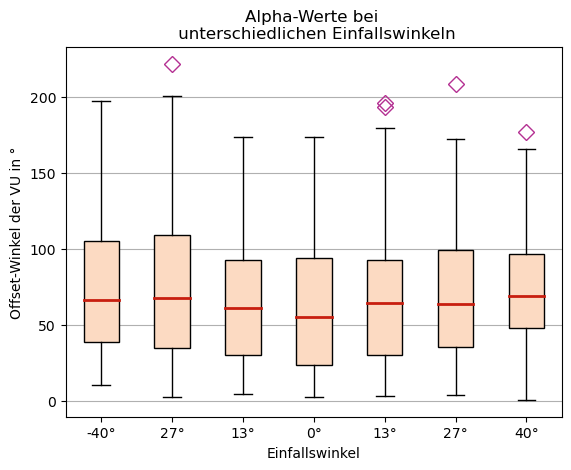

In [38]:
a_sums = get_samples_for_key_by_variable('A', angle_var, 'sum_injected_rotation_g_r(IN DEGREES)')
angle_values = {}
for i in range(len(a_sums)):
    angle_values[i] = []
    for values in list(a_sums[i].values()):
        for value in values:
            angle_values[i].append(value)
# print(len(angle_values))
# print(angle_values[0])
boxplot([angle_values[0], angle_values[1], angle_values[2], angle_values[3], angle_values[4], angle_values[5], angle_values[6]], title='Offset-Winkel der VU bei \n unterschiedlichen Einfallswinkeln', xlabel='Einfallswinkel', ylabel='Offset-Winkel der VU in °', value_names=['-40°', '27°', '13°', '0°', '13°', '27°', '40°'])

a_sums = get_samples_for_key_by_variable('B', angle_var, 'max_yaw_real')
angle_values = {}
for i in range(len(a_sums)):
    angle_values[i] = []
    for values in list(a_sums[i].values()):
        for value in values:
            angle_values[i].append(abs(value))
#print(len(angle_values[0]))
# print(angle_values[0])
boxplot([angle_values[0], angle_values[1], angle_values[2], angle_values[3], angle_values[4], angle_values[5], angle_values[6]],showfliers=True, title='Alpha-Werte bei \n unterschiedlichen Einfallswinkeln', xlabel='Einfallswinkel', ylabel='Offset-Winkel der VU in °', value_names=['-40°', '27°', '13°', '0°', '13°', '27°', '40°'])


###### t-Test everything against everything else

In [39]:
def test_group_differences(variable: variable, condition:int, group_a_key:str, group_b_key='', print_results=False, plot_data=False):
    if group_b_key == '':
        group_b_key = group_a_key

    hypothesis_counter = 0
    significant_trials = []

    a_conditions, b_conditions = get_grouped_samples_for_key_by_variable(variable, group_a_key, group_b_key)

    for id in variable.sliced_id_list:
        a = pd.Series(a_conditions[condition][f'{id}'])
        b = pd.Series(b_conditions[condition][f'{id}'])

        if print_results:
            print(f'Trial {id}:')
            hypothesis, _, _, _ = independent_test(a, b, print_results=True)
            print()
        else:
            hypothesis, _, _, _ = independent_test(a, b)

        if hypothesis:
            hypothesis_counter += 1
        else:
            significant_id = id[:variable.id_position] + '*' + id[variable.id_position:]
            significant_trials.append(significant_id)
        
        if plot_data:
            print(f'Trial {id}:')
            plot_test_data(a, b)

    print(f'{hypothesis_counter/len(variable.sliced_id_list)*100} % of {len(variable.sliced_id_list)} tested trials show no significant difference between group A and B.')
    print(f'The {len(significant_trials)} significant trials are: {significant_trials}')


def test_condition_differences(group:str, variable: variable, condition1:int, condition2:int, key:str, print_results=False, plot_data=False, except_var:variable=None, except_condition:int=None):
    hypothesis_counter = 0
    count = 0
    significant_trials = []

    if except_var != None:
        #print(f'excepting condition: {except_var.conditions[except_condition]}')
        if variable.id_position < except_var.id_position:
            except_id_pos = except_var.id_position - 1
        else:
            except_id_pos = except_var.id_position

    conditions = get_samples_for_key_by_variable(group, variable, key)

    for id in variable.sliced_id_list:
        if except_condition != None and int(id[except_id_pos]) == except_condition:
            continue
        count += 1

        a = pd.Series(conditions[condition1][f'{id}'])
        b = pd.Series(conditions[condition2][f'{id}'])

        if print_results:
            print(f'Trial {id}:')
            hypothesis, _, _, _ = independent_test(a, b, print_results=True)
            print()
        else:
            hypothesis, _, _, _ = independent_test(a, b)

        if hypothesis:
            hypothesis_counter += 1
        else:
            significant_id = id[:variable.id_position] + '*' + id[variable.id_position:]
            significant_trials.append(significant_id)
        
        if plot_data:
            print(f'Trial {id}:')
            plot_test_data(a, b)

    # print help variables
    con1 = variable.conditions[condition1]
    con2 = variable.conditions[condition2]

    print(f'{hypothesis_counter/count*100} % of {count} tested trials show no significant difference between {variable.name} conditions {con1} and {con2} in group {group}.')
    print(f'The {len(significant_trials)} significant trials are: {significant_trials}')


def test_group_differences_for_all_conditions(variable: variable, group_a_key:str, group_b_key='', print_results=False, plot_data=False):
    for i in range(len(variable.conditions)):
        test_group_differences(variable, i, group_a_key, group_b_key, print_results, plot_data)


def test_all_conditions_against(group:str, variable: variable, against_condition:int, key:str, print_results=False, plot_data=False, except_var:variable=None, except_condition:int=None):
    for i in range(len(variable.conditions)):
        if i == against_condition:
            continue
        test_condition_differences(group, variable, against_condition, i, key, print_results, plot_data, except_var, except_condition)


In [40]:
# test_group_differences_for_all_conditions(angle_var, 'max_yaw_real')
# test_group_differences_for_all_conditions(angle_var, 'max_yaw_virt', 'max_yaw_real')

ex_con = 2
test_all_conditions_against('B', angle_var, 0, 'max_yaw_real', except_var=speed_var, except_condition=ex_con)
print()
test_all_conditions_against('B', angle_var, 6, 'max_yaw_real', except_var=speed_var, except_condition=ex_con)
# print()
# test_all_conditions_against('A', angle_var, 0, 'max_yaw_virt')#, except_var=form_var, except_condition=ex_con)
# print()
# test_all_conditions_against('A', angle_var, 6, 'max_yaw_virt')#, except_var=form_var, except_condition=ex_con)


The effect size is d = 0.8064 (large).
The effect size is d = 0.925 (large).
83.33333333333334 % of 12 tested trials show no significant difference between angle conditions 40 and 27 in group B.
The 2 significant trials are: ['011*', '101*']
100.0 % of 12 tested trials show no significant difference between angle conditions 40 and 13 in group B.
The 0 significant trials are: []
The effect size is d = 0.7841 (medium).
The effect size is d = 0.8816 (large).
83.33333333333334 % of 12 tested trials show no significant difference between angle conditions 40 and 0 in group B.
The 2 significant trials are: ['211*', '011*']
The effect size is d = 0.9092 (large).
The effect size is d = 0.9888 (large).
The effect size is d = 0.8833 (large).
The effect size is d = 1.1934 (large).
The effect size is d = 1.2088 (large).
58.333333333333336 % of 12 tested trials show no significant difference between angle conditions 40 and -13 in group B.
The 5 significant trials are: ['211*', '000*', '100*', '011*'

In [41]:
# test_group_differences(form_var, 0, 'max_yaw_virt', 'max_yaw_real')
# test_group_differences(form_var, 1, 'max_yaw_virt', 'max_yaw_real')
# test_group_differences(form_var, 2, 'max_yaw_virt', 'max_yaw_real')

test_condition_differences('B', form_var, 0, 1, 'max_yaw_real')
test_condition_differences('B', form_var, 0, 2, 'max_yaw_real')
test_condition_differences('B', form_var, 1, 2, 'max_yaw_real')
print()
test_condition_differences('A', form_var, 0, 1, 'max_yaw_virt')
test_condition_differences('A', form_var, 0, 2, 'max_yaw_virt')
test_condition_differences('A', form_var, 1, 2, 'max_yaw_virt')

The effect size is d = -0.5958 (medium).
The effect size is d = -0.7948 (medium).
95.23809523809523 % of 42 tested trials show no significant difference between form conditions Sphere and Cylinder in group B.
The 2 significant trials are: ['*103', '*111']
The effect size is d = -0.9559 (large).
The effect size is d = -0.7535 (medium).
95.23809523809523 % of 42 tested trials show no significant difference between form conditions Sphere and Car in group B.
The 2 significant trials are: ['*103', '*111']
100.0 % of 42 tested trials show no significant difference between form conditions Cylinder and Car in group B.
The 0 significant trials are: []

The effect size is d = 0.7702 (medium).
97.61904761904762 % of 42 tested trials show no significant difference between form conditions Sphere and Cylinder in group A.
The 1 significant trials are: ['*120']
The effect size is d = 0.8878 (large).
97.61904761904762 % of 42 tested trials show no significant difference between form conditions Sphere a

In [42]:
for angle_i in range(len(angle_var.conditions)):
    for angle_j in range(len(angle_var.conditions)):
        if angle_i != angle_j:
            test_condition_differences('A', angle_var, angle_i, angle_j, 'sum_injected_rotation_g_r(IN DEGREES)')
        

The effect size is d = 0.7804 (medium).
94.44444444444444 % of 18 tested trials show no significant difference between angle conditions 40 and 27 in group A.
The 1 significant trials are: ['112*']
The effect size is d = 0.8984 (large).
The effect size is d = 0.9857 (large).
88.88888888888889 % of 18 tested trials show no significant difference between angle conditions 40 and 13 in group A.
The 2 significant trials are: ['202*', '012*']
The effect size is d = 0.8029 (large).
The effect size is d = 0.6334 (medium).
The effect size is d = 0.9757 (large).
The effect size is d = 1.2324 (large).
The effect size is d = 0.5741 (medium).
The effect size is d = 1.0242 (large).
The effect size is d = 0.9357 (large).
The effect size is d = 1.9411 (large).
The effect size is d = 0.7705 (medium).
50.0 % of 18 tested trials show no significant difference between angle conditions 40 and 0 in group A.
The 9 significant trials are: ['200*', '212*', '201*', '210*', '000*', '112*', '002*', '012*', '001*']

In [43]:
same = []
other = []
# check if the greatest max_yaw_virt has the same trialID as the greatest max_yaw_real for a given user_id
print('IDs and Values for Maxima:')

for id in a_result_dict:
    #for i in range(len(a_result_dict[id])):
    max_id_r = a_result_dict[id].loc[:,'max_yaw_real'].idxmax()
    min_id_r = a_result_dict[id].loc[:,'max_yaw_real'].idxmin()
    max_id_v = a_result_dict[id].loc[:,'max_yaw_virt'].idxmax()
    min_id_v = a_result_dict[id].loc[:,'max_yaw_virt'].idxmin()
    max_id_rot = a_result_dict[id].loc[:,'sum_injected_rotation_g_r(IN DEGREES)'].idxmax()
    if max_id_r == max_id_v:
        same.append([id, a_result_dict[id].iloc[max_id_r]["trialID"], a_result_dict[id].iloc[max_id_r]["max_yaw_real"], a_result_dict[id].iloc[max_id_r]["max_yaw_virt"]])
    else:
        other.append([id, 'real max:', a_result_dict[id].iloc[max_id_r]["trialID"], a_result_dict[id].iloc[max_id_r]["max_yaw_real"], a_result_dict[id].iloc[max_id_r]["max_yaw_virt"], 'virt max:', a_result_dict[id].iloc[max_id_v]["trialID"], a_result_dict[id].iloc[max_id_v]["max_yaw_real"], a_result_dict[id].iloc[max_id_v]["max_yaw_virt"]])

    r_max_id = a_result_dict[id].iloc[max_id_r]["trialID"]
    r_min_id = a_result_dict[id].iloc[min_id_r]["trialID"]
    v_max_id = a_result_dict[id].iloc[max_id_v]["trialID"]
    v_min_id = a_result_dict[id].iloc[min_id_v]["trialID"]
    rot_id = a_result_dict[id].iloc[max_id_rot]["trialID"]
    r_max_yaw = a_result_dict[id].iloc[max_id_r]["max_yaw_real"]
    r_min_yaw = a_result_dict[id].iloc[min_id_r]["max_yaw_real"]
    v_max_yaw = a_result_dict[id].iloc[max_id_v]["max_yaw_virt"]
    v_min_yaw = a_result_dict[id].iloc[min_id_v]["max_yaw_virt"]
    rot_val = a_result_dict[id].iloc[max_id_rot]["sum_injected_rotation_g_r(IN DEGREES)"]
    rot_v_yaw_val = a_result_dict[id].iloc[max_id_rot]["max_yaw_virt"]
    rot_r_yaw_val = a_result_dict[id].iloc[max_id_rot]["max_yaw_real"]

    print(f'R_Min: ID={r_min_id}, Value={r_min_yaw}')
    print(f'R_Max: ID={r_max_id}, Value={r_max_yaw}')
    print(f'__Rot: ID={rot_id}, Value={rot_val}, V_Yaw={rot_v_yaw_val}, R_Yaw={rot_r_yaw_val}')
    print()

print(f'The same: {len(same)}')
#print(f'The {other} ')#others: {other}')
#other
#print(results_where_key_is_max(a_result_dict, same[0][0], 'sum_injected_rotation_g_r(IN DEGREES)'))
#print(results_where_key_is_max(a_result_dict, same[0][0], 'max_yaw_virt'))
# print(1134/9)
# print('the maximum virtual yaw is always the same as the maximum real yaw')
#other

IDs and Values for Maxima:
R_Min: ID=1113, Value=-118.4477
R_Max: ID=0104, Value=148.1617
__Rot: ID=0104, Value=53.50099, V_Yaw=145.4198, R_Yaw=148.1617

R_Min: ID=1012, Value=-163.3654
R_Max: ID=2100, Value=160.7902
__Rot: ID=1005, Value=38.12798, V_Yaw=69.61877, R_Yaw=-76.98266

R_Min: ID=1122, Value=-145.6831
R_Max: ID=0001, Value=83.74387
__Rot: ID=2104, Value=54.91309, V_Yaw=-69.06892, R_Yaw=-71.50335

R_Min: ID=1105, Value=-182.865
R_Max: ID=1111, Value=175.3434
__Rot: ID=1105, Value=63.86304, V_Yaw=-135.7044, R_Yaw=-182.865

R_Min: ID=0105, Value=-152.671
R_Max: ID=1101, Value=209.5399
__Rot: ID=1006, Value=50.38511, V_Yaw=-80.27885, R_Yaw=-109.3973

R_Min: ID=1106, Value=-169.3482
R_Max: ID=2001, Value=60.25116
__Rot: ID=0106, Value=47.82547, V_Yaw=-115.3695, R_Yaw=-120.7049

R_Min: ID=1115, Value=-158.1191
R_Max: ID=1020, Value=219.0554
__Rot: ID=1101, Value=49.96778, V_Yaw=133.0212, R_Yaw=139.1646

R_Min: ID=1006, Value=-169.4794
R_Max: ID=1013, Value=213.1097
__Rot: ID=2002,

***
### Pandas/Numpy cheat sheet

reference Samples

In [44]:
user_id = "A10"
trial_iteration = 25
sample = 2
sample_key = "g_r"

# get the whole dataframe of a trial
a_sample_dict[user_id][trial_iteration]

# get sample list:
a_sample_dict[user_id][trial_iteration][sample_key]

# get all values from specific sample
a_sample_dict[user_id][trial_iteration].iloc[sample]

# get a specific value 
a_sample_dict[user_id][trial_iteration].iloc[sample][sample_key]

# print all sample key names
a_sample_dict[user_id][trial_iteration].columns

Index(['sampling_intervals', 'g_r', 'injected_rotations',
       'real_rotation_accumulation',
       'additional_virtual_rotation_accumulation', 'real_position',
       'virtual_position', 'real_direction', 'virtual_direction', 'real_euler',
       'virtual_euler', 'real_rotation', 'virtual_rotation',
       'relative_virt_position', 'Unnamed: 14'],
      dtype='object')

reference Results

In [45]:
user_id = "A10"
trial_iteration = 25
trial = 80
column = "sum_injected_rotation_g_r(IN DEGREES)"

# get the whole result dataframe of a trial
a_result_dict[user_id]
# get a column:
a_result_dict[user_id][column]
# get a row
a_result_dict[user_id].iloc[trial]
# get a specific value
a_result_dict[user_id].iloc[trial][column]
# print all column names
b_result_dict['B4'].columns

Index(['TrialIteration', 'EndState', 'experiment_start_time', 'trialID',
       'form', 'size', 'speed', 'angle', 'experiment_duration',
       'average_sampling_interval', 'sum_real_distance_travelled(IN METERS)',
       'max_distance_to_center', 'real_pos_at_max_dist',
       'virt_pos_at_max_dist', 'max_yaw_real', 'real_dir_at_real_yaw',
       'virt_dir_at_real_yaw', 'real_pos_at_real_yaw', 'virt_pos_at_real_yaw'],
      dtype='object')

split multidimensional samples with .split(",") like this:

In [46]:
x, y, z, w = a_result_dict[user_id].iloc[trial_iteration]['real_rot_at_real_yaw'].split(',')
print(x)
print(y)
print(z)
print(w)

0.02172193
 -0.305534
 -0.01428093
 -0.9518262


***

In [47]:
def results_where_key_is_max(user_id, key):
    if('A' in user_id):
        select_dict = a_result_dict
    else:
        select_dict = b_result_dict

    max_id = select_dict[user_id].loc[:, key].idxmax()
    print("TrialID:", select_dict[user_id].loc[max_id, 'trialID'])
    print("Form:", select_dict[user_id].loc[max_id, 'form'])
    print("Size:", select_dict[user_id].loc[max_id, 'size'])
    print("Speed:", select_dict[user_id].loc[max_id, 'speed'])
    print("Angle:", select_dict[user_id].loc[max_id, 'angle'])
    if('A' in user_id):
        print('A' in user_id)
        print("min g/r:", select_dict[user_id].loc[max_id, 'min_g_r'])
        print("max g/r:", select_dict[user_id].loc[max_id, 'max_g_r'])
        print("g/r average:", select_dict[user_id].loc[max_id, 'g_r_average'])
        print("max virt Yaw:", select_dict[user_id].loc[max_id, 'max_yaw_virt'])
    print("max real Yaw:", select_dict[user_id].loc[max_id, 'max_yaw_real'])

    min_id = select_dict[user_id].loc[:, key].idxmin()
    if(select_dict[user_id].loc[max_id, key] < abs(select_dict[user_id].loc[min_id, key])):
        print()
        print("But absolute maximum is")
        results_where_key_is_min(select_dict ,user_id, key)

def results_where_key_is_min(user_id, key):
    if('A' in user_id):
        select_dict = a_result_dict
    else:
        select_dict = b_result_dict

    min_id = select_dict[user_id].loc[:, key].idxmin()
    print("TrialID:", select_dict[user_id].loc[min_id, 'trialID'])
    print("Form:", select_dict[user_id].loc[min_id, 'form'])
    print("Size:", select_dict[user_id].loc[min_id, 'size'])
    print("Speed:", select_dict[user_id].loc[min_id, 'speed'])
    print("Angle:", select_dict[user_id].loc[min_id, 'angle'])
    if('A' in user_id):
        print('A' in user_id)
        print("min g/r:", select_dict[user_id].loc[min_id, 'min_g_r'])
        print("max g/r:", select_dict[user_id].loc[min_id, 'max_g_r'])
        print("g/r average:", select_dict[user_id].loc[min_id, 'g_r_average'])
        print("max virt Yaw:", select_dict[user_id].loc[min_id, 'max_yaw_virt'])
    print("max real Yaw:", select_dict[user_id].loc[min_id, 'max_yaw_real'])

# create a numpy array of all the values in the column
results_where_key_is_min('A12', 'max_yaw_virt')

TrialID: 1105
Form: Cylinder
Size: 0.8
Speed: 18
Angle: -27
True
min g/r: -1.931516
max g/r: 3.362232
g/r average: 0.006866928
max virt Yaw: -135.7044
max real Yaw: -182.865
